# Описание проекта

__Проект: Обучение с учителем: качество модели__

__Описание проекта__

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


__Цель исследования__

Определить ключевые факторы, влияющие на снижение покупательской активности, и выявить группы клиентов с различным уровнем риска и прибыльности.

Построить и сравнить модели классификации для прогноза вероятности снижения активности, выбрать оптимальную по метрике **ROC-AUC**.

Провести сегментацию покупателей на основе предсказанных рисков и прибыльности, определить приоритетные сегменты для бизнес-работы и разработать рекомендации по повышению активности клиентов.


__Ход исследования__

1. [Загрузка данных](#загрузка_данных)  
2. [Предобработка данных](#предобработка_данных)  
3. [Исследовательский анализ данных](#исследовательский_анализ_данных)  
4. [Объединение таблиц](#объединение_таблиц)  
5. [Корреляционный анализ](#корреляционный_анализ)  
6. [Использование пайплайнов](#использование_пайплайнов)  
7. [Анализ важности признаков](#анализ_важности_признаков)  
8. [Сегментация покупателей](#сегментация_покупателей)  
9. [Общий вывод](#общий_вывод)  

## Загрузка данных <a id="загрузка_данных"></a>

In [1]:
# Для установки модуля 'phik' 
!pip install -q phik

In [2]:
# Обновим scikit-learn, чтобы получить ColumnTransformer.get_feature_names_out()
!pip install -q -U scikit-learn

In [3]:
# Для установки модуля 'shap' 
!pip install -q shap

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from scipy.stats import normaltest
import warnings, re
import sklearn
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(transform_output="pandas")

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Настройки окружения и константы проекта
warnings.filterwarnings(
    "ignore",
    message=".*keepdims.*",
    category=FutureWarning
)

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [5]:
# Загружаем датасеты
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

## Предобработка данных <a id="предобработка_данных"></a>

__Создадим функцию для вывода нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)__

In [6]:
def my_func(x):
    print('------------- Исходный датафрейм -------------')
    display(x.head())
    print('')
    print('')
    print('------------- Общая информация о датафрейме -------------')
    print('')
    print('')
    display(x.info())
    print('------------- Количество пустых значений в датафрейме -------------')
    print('')
    print('')
    display(x.isna().sum())
    print('------------- Количество явных дубликатов в датафрейме -------------')
    display(x.duplicated().sum())
    print('')
    print('')
    print('------------- Описательная статистика -------------')
    display(x.describe())
    print('------------- Проверим уникальные значения нечисловых колонок -------------')
    print('')
    print('')
    object_cols = x.select_dtypes(include='object').columns
    for col in object_cols:
        unique_vals = x[col].unique()
        print(f"Столбец: {col}")
        print(f"Количество уникальных значений: {len(unique_vals)}")
        print(f"Уникальные значения: {unique_vals}")
        print('-' * 60)

### Вывод market_file нужных характеристик

In [7]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
my_func(market_file)

------------- Исходный датафрейм -------------


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал

None

------------- Количество пустых значений в датафрейме -------------




id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: Покупательская активность
Количество уникальных значений: 2
Уникальные значения: ['Снизилась' 'Прежний уровень']
------------------------------------------------------------
Столбец: Тип сервиса
Количество уникальных значений: 3
Уникальные значения: ['премиум' 'стандартт' 'стандарт']
------------------------------------------------------------
Столбец: Разрешить сообщать
Количество уникальных значений: 2
Уникальные значения: ['да' 'нет']
------------------------------------------------------------
Столбец: Популярная_категория
Количество уникальных значений: 6
Уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
------------------------------------------------------------


### Вывод market_money нужных характеристик

In [8]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
my_func(market_money)

------------- Исходный датафрейм -------------


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

------------- Количество пустых значений в датафрейме -------------




id         0
Период     0
Выручка    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: Период
Количество уникальных значений: 3
Уникальные значения: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
------------------------------------------------------------


### Вывод market_time нужных характеристик

In [9]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)
my_func(market_time)

------------- Исходный датафрейм -------------


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

------------- Количество пустых значений в датафрейме -------------




id        0
Период    0
минут     0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


------------- Проверим уникальные значения нечисловых колонок -------------


Столбец: Период
Количество уникальных значений: 2
Уникальные значения: ['текущий_месяц' 'предыдцщий_месяц']
------------------------------------------------------------


### Вывод money нужных характеристик

In [10]:
# Вывод нужных характеристик (head, info, describe, пропуски, дубликаты)
my_func(money)

------------- Исходный датафрейм -------------


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21




------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

------------- Количество пустых значений в датафрейме -------------




id         0
Прибыль    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


np.int64(0)



------------- Описательная статистика -------------


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


------------- Проверим уникальные значения нечисловых колонок -------------




### Выводы по данным

* Структура всех таблиц и типы столбцов соответствуют описанию.
* Критичных проблем (пропусков, дублей) — нет.
* Требуется очистка категорий (исправить опечатки/нормализовать регистры/пробелы)

__Проблемы:__

* Названия колонок не унифицированы — встречаются пробелы и разные регистры.
* Опечатки в категориальных значениях: `Тип сервиса` содержит «стандартт»; `Популярная_категория` — «Косметика и аксесуары».
* Несогласованные значения периода: в `market_time` встречается «предыдцщий_месяц» вместо «предыдущий_месяц».

__Решения:__

* Унифицировать названия колонок — привести их к нижнему регистру и заменить пробелы на подчёркивания
* Нормализовать категориальные значения: `str.strip().str.lower()` + маппинги (`{'стандартт':'стандарт', 'косметика и аксесуары':'косметика и аксессуары'}`).
* Привести `Период` к единому справочнику: заменить `предыдцщий_месяц` → `предыдущий_месяц`.



### Решение обнаруженных проблем

#### Унифицировать названия колонок — привести их к нижнему регистру и заменить пробелы на подчёркивания

In [11]:
#Ззаменим пробелы на подчёркивания в названиях всех колонок и приведём названия колонок к нижнему регистру
def rename_columns_with_spaces(df):
    df.columns = [col.replace(' ', '_').lower() for col in df.columns]
    return df

# Применяем к таблицам
market_file = rename_columns_with_spaces(market_file)
market_money = rename_columns_with_spaces(market_money)
market_time = rename_columns_with_spaces(market_time)
money = rename_columns_with_spaces(money)

# Проверим
print(market_file.columns)
print('')
print(market_money.columns)
print('')
print(market_time.columns)
print('')
print(money.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Index(['id', 'период', 'выручка'], dtype='object')

Index(['id', 'период', 'минут'], dtype='object')

Index(['id', 'прибыль'], dtype='object')


#### Нормализация строковых колонок (обрезка пробелов, единообразные пробелы)

In [12]:
cat_cols_file = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for col in cat_cols_file:
    market_file[col] = (market_file[col]
                        .astype(str)
                        .str.strip()
                        .str.replace(r'\s+', ' ', regex=True))

In [13]:
# Проверка
cols = market_file.select_dtypes(include='object').columns
for col in cols:
        unique_vals = market_file[col].unique()
        print(f"Столбец: {col}")
        print(f"Количество уникальных значений: {len(unique_vals)}")
        print(f"Уникальные значения: {unique_vals}")

Столбец: покупательская_активность
Количество уникальных значений: 2
Уникальные значения: ['Снизилась' 'Прежний уровень']
Столбец: тип_сервиса
Количество уникальных значений: 3
Уникальные значения: ['премиум' 'стандартт' 'стандарт']
Столбец: разрешить_сообщать
Количество уникальных значений: 2
Уникальные значения: ['да' 'нет']
Столбец: популярная_категория
Количество уникальных значений: 6
Уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


#### Исправление опечаток в категориальных признаках

In [14]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace({'стандартт': 'стандарт'})
market_file['популярная_категория'] = market_file['популярная_категория'].replace({'Косметика и аксесуары': 'Косметика и аксессуары'})
market_time['период'] = market_time['период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

In [15]:
# Проверка

print(f"Уникальные значения 'тип_сервиса': {market_file['тип_сервиса'].unique()}")
print('')
print(f"Уникальные значения 'популярная_категория': {market_file['популярная_категория'].unique()}")
print('')
print(f"Уникальные значения 'период': {market_time['период'].unique()}")

Уникальные значения 'тип_сервиса': ['премиум' 'стандарт']

Уникальные значения 'популярная_категория': ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Уникальные значения 'период': ['текущий_месяц' 'предыдущий_месяц']


### Вывод о выполненных действиях

1. **Унификация названий колонок**
   Все названия столбцов приведены к нижнему регистру и записаны в формате `snake_case`.

2. **Нормализация строковых данных**
   Для всех категориальных признаков удалены лишние пробелы, приведены к единому регистру.

3. **Исправление опечаток**
   В столбце `тип_сервиса` исправлена ошибка «стандартт» → «стандарт»,
   В столбце `популярная_категория` — «Косметика и аксесуары» → «Косметика и аксессуары».
   Также исправлена опечатка в `market_time['период']`: «предыдцщий_месяц» заменено на «предыдущий_месяц».
   
4. **Проверка на пропуски и дубликаты.**
   Пропуски и дубли в данных отсутствуют, что подтверждает корректность исходных таблиц.
5. **Проверка типов данных.**
   Типы данных соответствуют содержимому признаков, числовые колонки сохранены в числовом формате, строковые — в категориальном.

**Итог:**
Проведена базовая предобработка и очистка данных — таблицы приведены к единообразному виду, устранены опечатки и лишние пробелы.


## Исследовательский анализ данных <a id="исследовательский_анализ_данных"></a>

__Создадим вспомогательные функции для EDA: для числовых признаков выводим описательную статистику, гистограмму и boxplot; для категориальных — описательную статистику и столбчатую диаграмму распределения.__

__Разделение признаков на continuous / discrete / category:__

In [16]:
# категориальные
category = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
    'период'
]

# дискретные числовые (с
discrete = [
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'текущий_месяц_минут',
    'предыдущий_месяц_минут',
]

# непрерывные числовые
continuous = [
    'маркет_актив_6_мес',
    'длительность',
    'акционные_покупки',
    'выручка',
    'текущий_месяц_выручка',
    'предыдущий_месяц_выручка',
    'препредыдущий_месяц_выручка',
    'прибыль',
]


__Словарь подписей: ключ = имя столбца, значение = [title, xlabel, ylabel]:__

In [17]:
label_dict = {
    # категориальные
    'покупательская_активность': ["Распределение целевого класса", "Класс активности", "Количество клиентов"],
    'тип_сервиса': ["Распределение типа сервиса", "Тип сервиса", "Количество клиентов"],
    'разрешить_сообщать': ["Согласие на коммуникации", "Согласие (да/нет)", "Количество клиентов"],
    'популярная_категория': ["Популярная категория", "Категория", "Количество клиентов"],
    'период': ["Период наблюдения", "Период (месяц)", "Количество записей"],

    # дискретные числовые
    'маркет_актив_тек_мес': ["Коммуникации в текущем месяце", "Касаний", "Количество наблюдений"],
    'средний_просмотр_категорий_за_визит': ["Среднее число категорий за визит", "Категорий/визит", "Количество наблюдений"],
    'неоплаченные_продукты_штук_квартал': ["Неоплаченные товары за квартал", "Штук", "Количество наблюдений"],
    'ошибка_сервиса': ["Ошибки сервиса за 3 месяца", "Случаев", "Количество наблюдений"],
    'страниц_за_визит': ["Глубина просмотра", "Страниц/визит", "Количество наблюдений"],
    'минут': ["Время на сайте", "Минуты", "Количество наблюдений"],
    'текущий_месяц_минут': ["Время на сайте — текущий месяц", "Минут", "Количество наблюдений"],
    'предыдущий_месяц_минут': ["Время на сайте — предыдущий месяц", "Минут", "Количество наблюдений"],
    
    # непрерывные числовые (market_file)
    'маркет_актив_6_мес': ["Среднемес. коммуникации за 6 мес", "Касаний/мес", "Количество наблюдений"],
    'длительность': ["Длительность с регистрации", "Дней", "Количество наблюдений"],
    'акционные_покупки': ["Доля акционных покупок", "Доля (0–1)", "Количество наблюдений"],
    'текущий_месяц_выручка': ["Выручка — текущий месяц", "У. е.", "Количество наблюдений"],
    'предыдущий_месяц_выручка': ["Выручка — предыдущий месяц", "У. е.", "Количество наблюдений"],
    'препредыдущий_месяц_выручка': ["Выручка — позапрошлый месяц", "У. е.", "Количество наблюдений"],
    'прибыль': ["Среднемес. прибыль (3 мес)", "У. е.", "Количество наблюдений"],
    'выручка': ["Общая выручка за период", "Выручка (у. е.)", "Количество наблюдений"],
}

In [18]:
def learn_data(df):
    def get_labels(col):
        vals = label_dict.get(col, None)
        if vals is None:
            return [f"Распределение: {col}", col, "Количество наблюдений"]
        vals = list(vals) + [""] * (3 - len(vals))
        return vals[:3]

    for col in df.columns:
        if col == 'id':
            continue

        print(f"\n==== {col} ==== \n")
        title, xlabel, ylabel = get_labels(col)

        # Непрерывные
        if col in continuous:
            print(df[col].describe(), "\n")

            # Гистограмма
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=30)
            plt.title(title if title else f"Гистограмма: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.tight_layout()
            plt.show()

            # Boxplot
            plt.figure(figsize=(4, 6))
            plt.boxplot(df[col].dropna(), vert=True, showmeans=True)
            plt.title(f"Boxplot: {col}")
            plt.ylabel(xlabel if xlabel else col)
            plt.tight_layout()
            plt.show()

        # Дискретные
        elif col in discrete:
            print(df[col].describe(), "\n")

            plt.figure(figsize=(6, 4))
            df[col].value_counts(dropna=False).sort_index().plot(
                kind="bar", grid=True
            )
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        # Категориальные
        elif col in category:
            print(df[col].describe(), "\n")

            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

        else:
            # Фоллбэк для непомеченных колонок
            print(df[col].describe(), "\n")
            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Распределение: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Количество наблюдений")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()


==== покупательская_активность ==== 

count                1300
unique                  2
top       Прежний уровень
freq                  802
Name: покупательская_активность, dtype: object 



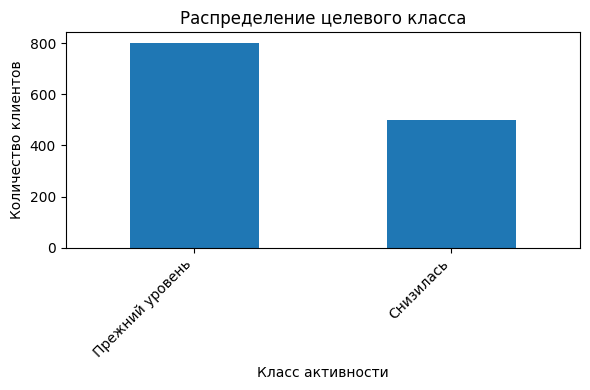


==== тип_сервиса ==== 

count         1300
unique           2
top       стандарт
freq           924
Name: тип_сервиса, dtype: object 



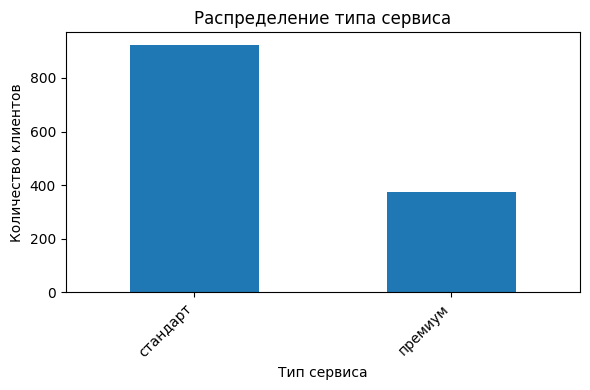


==== разрешить_сообщать ==== 

count     1300
unique       2
top         да
freq       962
Name: разрешить_сообщать, dtype: object 



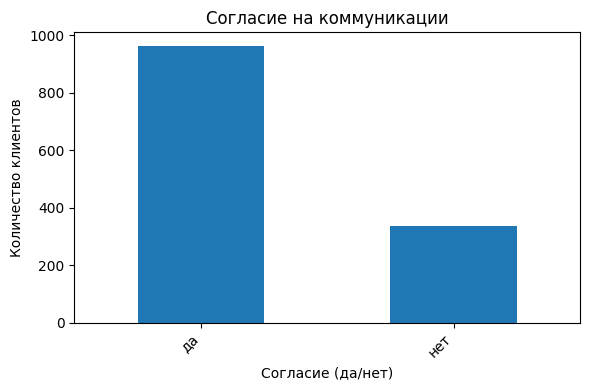


==== маркет_актив_6_мес ==== 

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64 



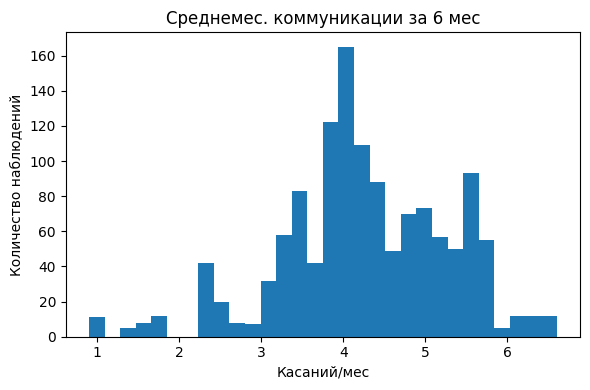

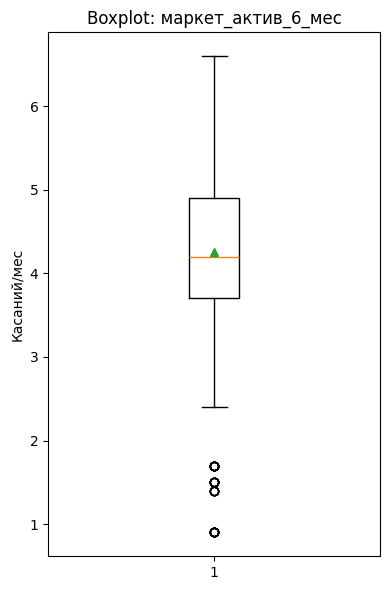


==== маркет_актив_тек_мес ==== 

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64 



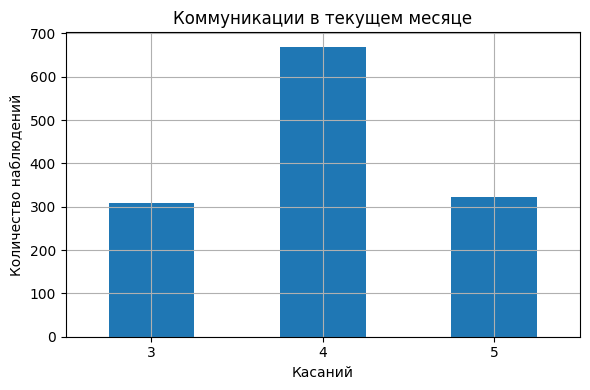


==== длительность ==== 

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64 



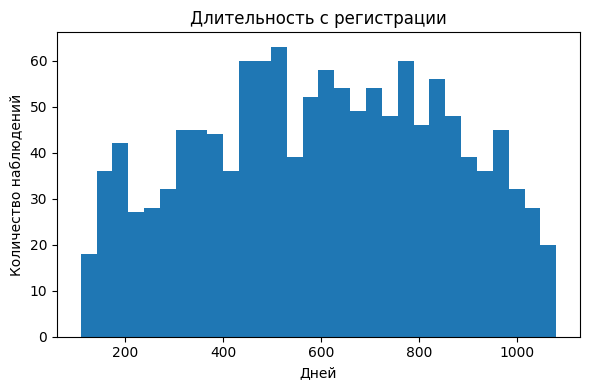

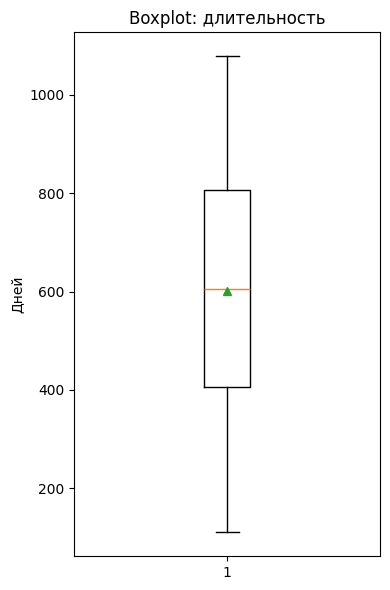


==== акционные_покупки ==== 

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64 



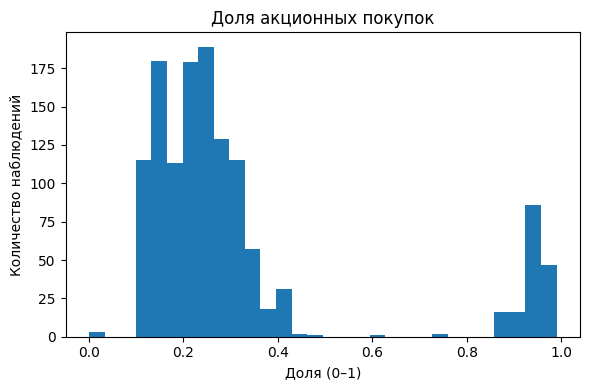

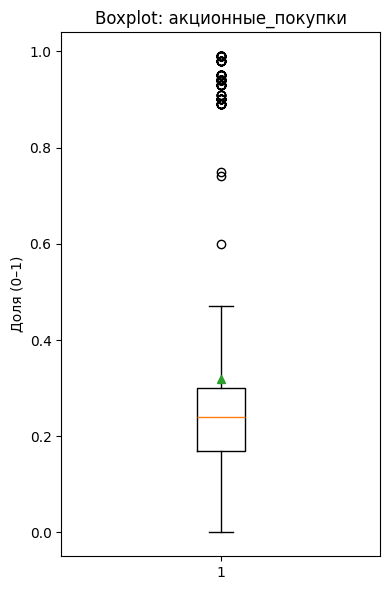


==== популярная_категория ==== 

count                 1300
unique                   6
top       Товары для детей
freq                   330
Name: популярная_категория, dtype: object 



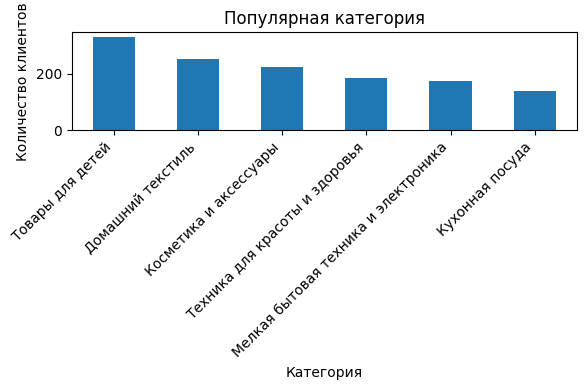


==== средний_просмотр_категорий_за_визит ==== 

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64 



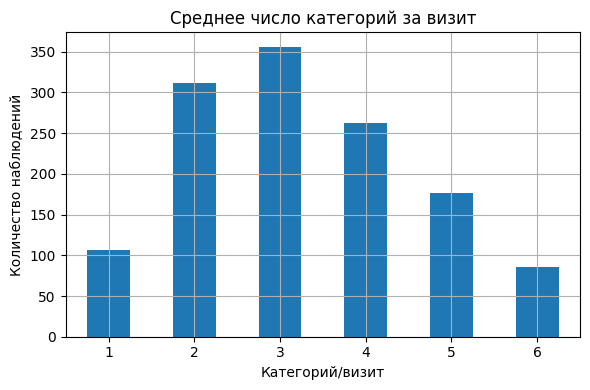


==== неоплаченные_продукты_штук_квартал ==== 

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64 



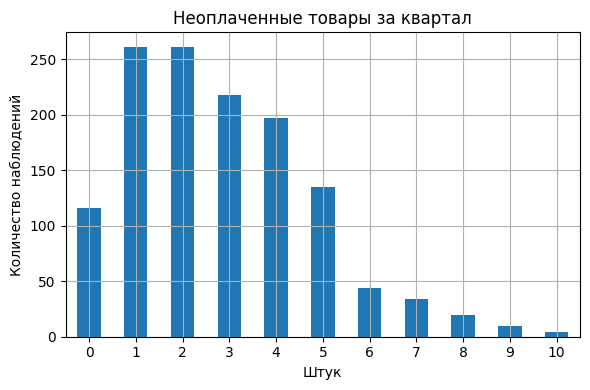


==== ошибка_сервиса ==== 

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64 



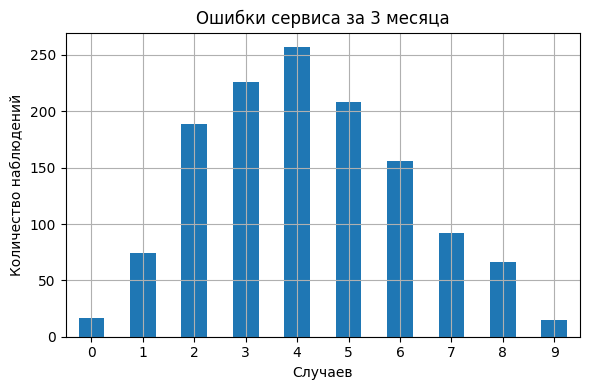


==== страниц_за_визит ==== 

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64 



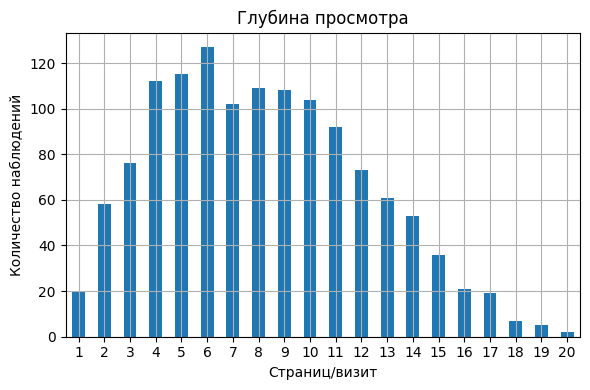

In [19]:
learn_data(market_file)


==== период ==== 

count                    3900
unique                      3
top       препредыдущий_месяц
freq                     1300
Name: период, dtype: object 



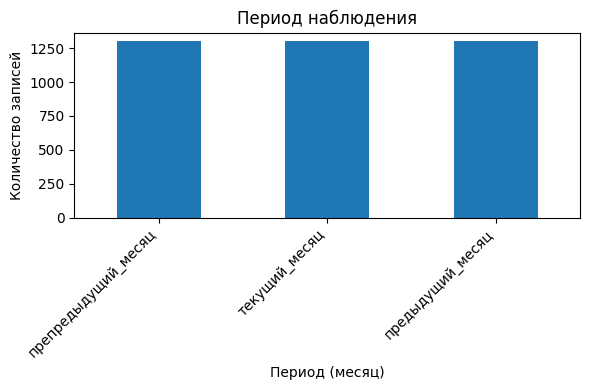


==== выручка ==== 

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64 



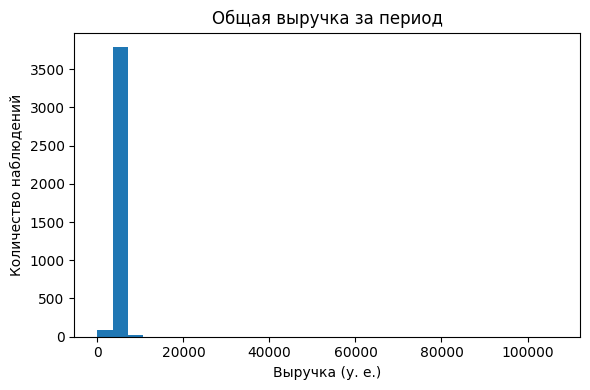

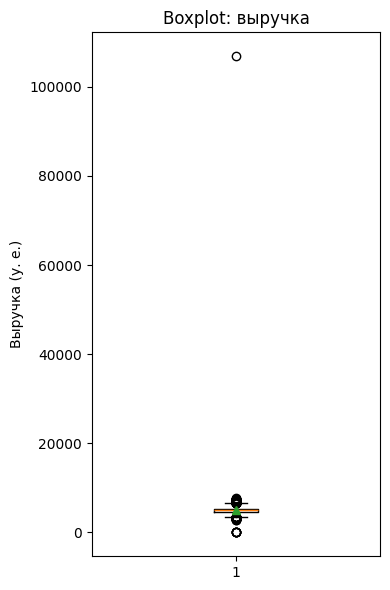

In [20]:
learn_data(market_money)


==== период ==== 

count              2600
unique                2
top       текущий_месяц
freq               1300
Name: период, dtype: object 



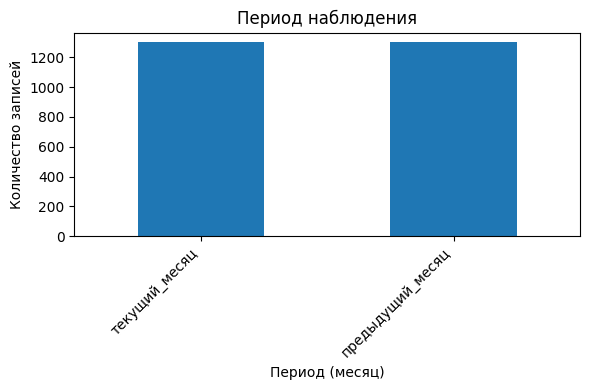


==== минут ==== 

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64 



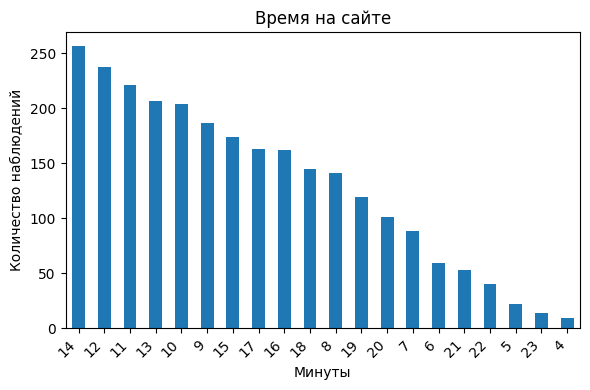

In [21]:
learn_data(market_time)


==== прибыль ==== 

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64 



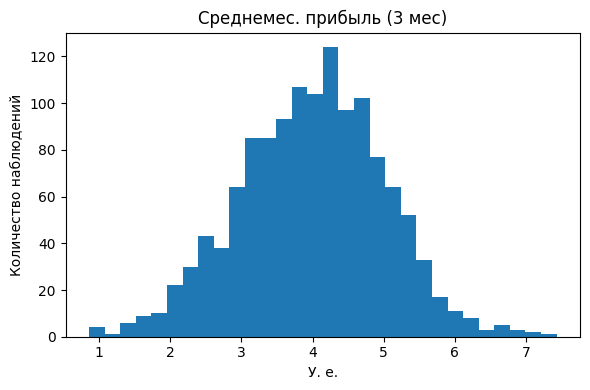

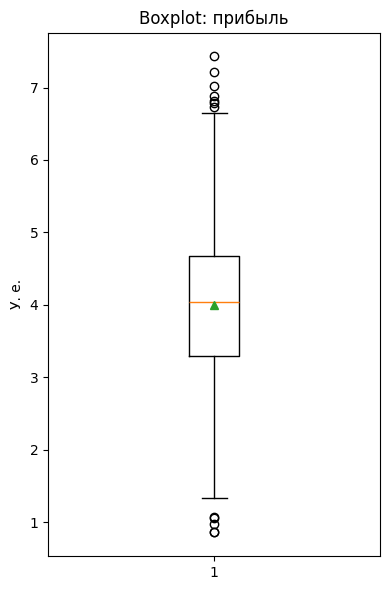

In [22]:
learn_data(money)

### Исследовательский анализ - выводы 

**1) Целевой признак**

* **Цель**: `покупательская_активность` — классы *«Прежний уровень»* и *«Снизилась»*.
* **Распределение**: *Прежний уровень* — **61.69%** (802 клиентов), *Снизилась* — **38.31%** (498 клиентов).
  **Вывод:** умеренный дисбаланс (≈62/38). Для модели — стратифицированное разбиение.

**2) Категориальные признаки**

* **Тип сервиса**: *стандарт* — **924**, *премиум* — **376**.
* **Разрешить сообщать**: *да* — **962**, *нет* — **338**.
* **Популярная категория (топ-3)**:

  1. *Товары для детей*
  2. *Домашний текстиль*
  3. *Косметика и аксессуары*


**3) Числовые признаки (market_file)**

Ключевые показатели (**min / median / mean / max**):

* **маркет_актив_6_мес**: 0.9 / **4.20** / 4.25 / 6.6
* **маркет_актив_тек_мес**: 3.0 / **4.00** / 4.01 / 5.0
* **длительность** (дней с регистрации): 110 / **606** / 601.9 / 1079
* **акционные_покупки** (доля): 0.00 / **0.24** / 0.32 / 0.99
* **средний_просмотр_категорий_за_визит**: 1 / **3** / 3.27 / 6
* **неоплаченные_продукты_штук_квартал**: 0 / **3** / 2.84 / 10
* **ошибка_сервиса**: 0 / **4** / 4.19 / 9
* **страниц_за_визит**: 1 / **8** / 8.18 / 20

**Наблюдения по распределениям:**

* Маркетинг в среднем **стабилен**: текущий месяц ≈ 4 коммуникаций, 6-месячная средняя ≈ 4.25.
* **Акционные покупки** заметно варьируются (до 0.99), медиана 0.24.
* **Активность на сайте**: медиана 8 страниц за визит и 3 категории; есть пользователи с очень низкой и высокой активностью

**4) Денежные метрики (market_money) по периодам**

min 0 / **median 4957.5** / mean 5025.7 / max 106862.2
**Динамика**: есть **сильный правый хвост** (редкие очень крупные траты).


**5) Время на сайте (market_time) по периодам**

min 4 / **median 13.0** / mean 13.34 / max 23

**6) Среднемесячная прибыль продавца (money)**

* **Прибыль**: min 0.86 / **median 4.05** / mean 4 / max 7.43 (условн. ед.).
  Распределение компактное, без отрицательных значений.


__Аномалии__
- Выручка имеет сильный правый хвост (max ≈ 106k).
- Остальные фичи выглядят разумно по диапазонам; аномалий с отрицательными значениями нет.

__Фильтруем строки с аномально высокой выручкой__

In [23]:
upper_bound = market_money['выручка'].median() * 2

anomalies = market_money[market_money['выручка'] > upper_bound]

print(f'Количество аномалий: {anomalies.shape[0]}')
display(anomalies.sort_values(by='выручка', ascending=False))


Количество аномалий: 1


,id,период,выручка
98,215380,текущий_месяц,106862.2


In [24]:
market_money[market_money['id']==215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


У клиента id = 215380 в двух предыдущих месяцах:

- 5051 и 6077 (нормальные значения),

- затем внезапно 106 862 — в 20 раз выше.

Поскольку нет признаков системной ошибки, можно считать, что это разовый всплеск или вводная ошибка. Поэтому уместно заменить выручку текущего месяца на значение, предсказанное из “нормального” поведения клиента — например, среднее или медиану предыдущих месяцев.

__Cреднее предыдущих периодов__

In [25]:
prev_values_mean = market_money.query("id == 215380 and период != 'текущий_месяц'")['выручка'].mean()
prev_values_mean

np.float64(5564.0)

__Также можно рассмотреть среднее или медиану “похожих” покупателей__ -

In [26]:
market_file[market_file['id']==215380]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


__Возьмем медиану клиентов того же типа: смотрим покупателей по типу сервиса Премиум__

In [27]:
median_similar = (
    market_money.merge(market_file[['id','тип_сервиса', 'популярная_категория']], on='id')
    .query("тип_сервиса == 'премиум' and период == 'текущий_месяц' and id != 215380")
    ['выручка']
    .median()
)
median_similar

5197.3

__В целом 5564.0 и 5197.3 близки по значению.
Мы решили взять среднее покупателя по предыдущим месяцам (5564).__

__Заменим выручку текущего месяца:__

In [28]:
market_money.loc[(market_money['id'] == 215380) & (market_money['период'] == 'текущий_месяц'), 'выручка'] = prev_values_mean

__Проверка__

In [29]:
market_money[market_money['id']==215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,5564.0


### Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

__Преобразуем market_money из длинного формата в широкий (по периодам)__

In [30]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [31]:
rev_pivot = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
rev_pivot

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [32]:
buyers_3m = rev_pivot.loc[(rev_pivot[['текущий_месяц','предыдущий_месяц','препредыдущий_месяц']] > 0).all(axis=1)].reset_index()
buyers_3m.columns.name = None
buyers_3m = buyers_3m.rename(columns={
    'текущий_месяц': 'текущий_месяц_выручка',
    'предыдущий_месяц': 'предыдущий_месяц_выручка',
    'препредыдущий_месяц': 'препредыдущий_месяц_выручка'
})
buyers_3m

,id,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6



==== предыдущий_месяц_выручка ==== 

count    1297.000000
mean     4948.339630
std       701.228571
min      2890.000000
25%      4498.500000
50%      5005.500000
75%      5409.000000
max      6869.500000
Name: предыдущий_месяц_выручка, dtype: float64 



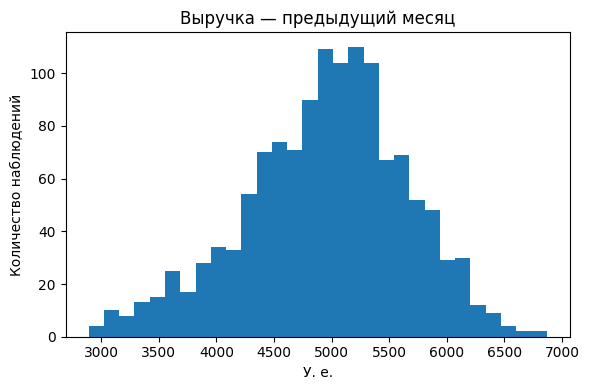

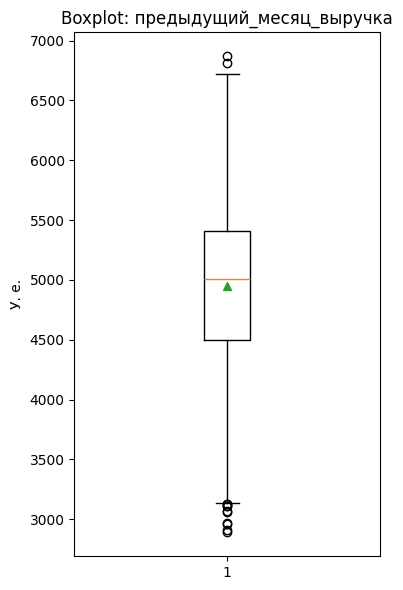


==== препредыдущий_месяц_выручка ==== 

count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: препредыдущий_месяц_выручка, dtype: float64 



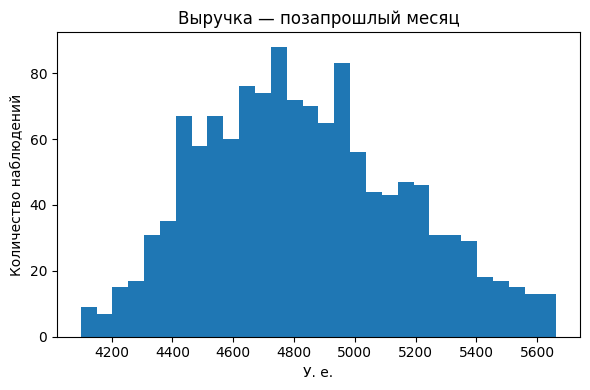

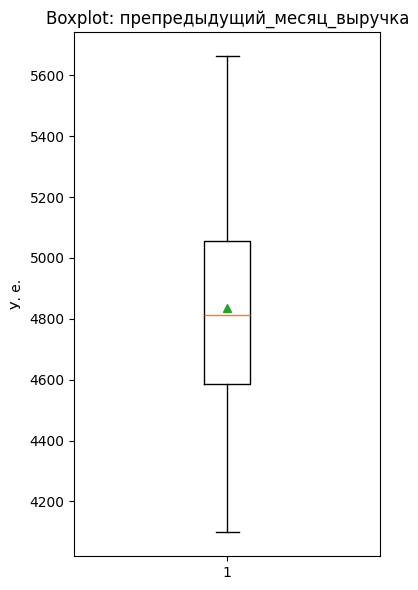


==== текущий_месяц_выручка ==== 

count    1297.000000
mean     5238.347340
std       834.045867
min      2758.700000
25%      4706.600000
50%      5180.300000
75%      5758.600000
max      7799.400000
Name: текущий_месяц_выручка, dtype: float64 



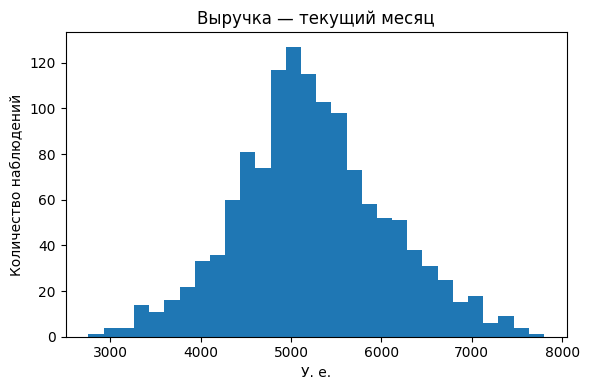

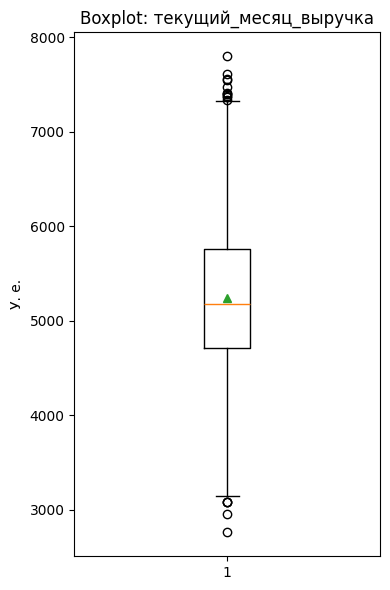

In [33]:
learn_data(buyers_3m)

In [34]:
filtered_market = market_file[market_file['id'].isin(buyers_3m['id'])]
filtered_market_time = market_time[market_time['id'].isin(buyers_3m['id'])]
filtered_money = money[money['id'].isin(buyers_3m['id'])]


==== покупательская_активность ==== 

count                1297
unique                  2
top       Прежний уровень
freq                  802
Name: покупательская_активность, dtype: object 



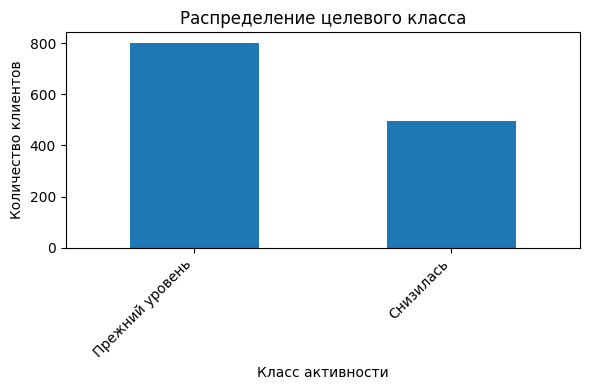


==== тип_сервиса ==== 

count         1297
unique           2
top       стандарт
freq           922
Name: тип_сервиса, dtype: object 



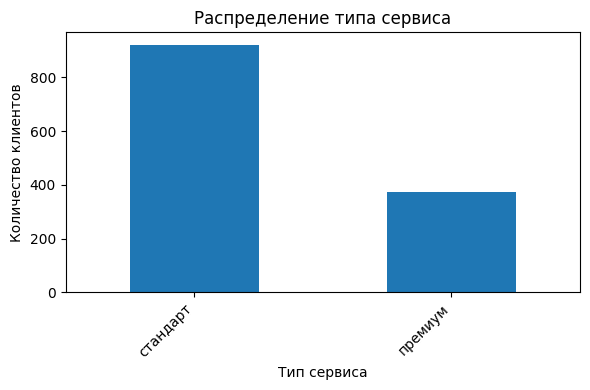


==== разрешить_сообщать ==== 

count     1297
unique       2
top         да
freq       959
Name: разрешить_сообщать, dtype: object 



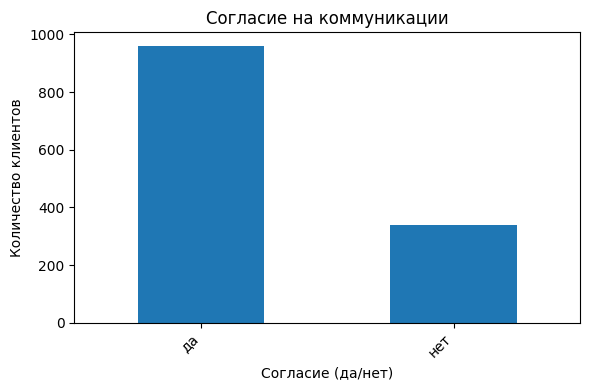


==== маркет_актив_6_мес ==== 

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64 



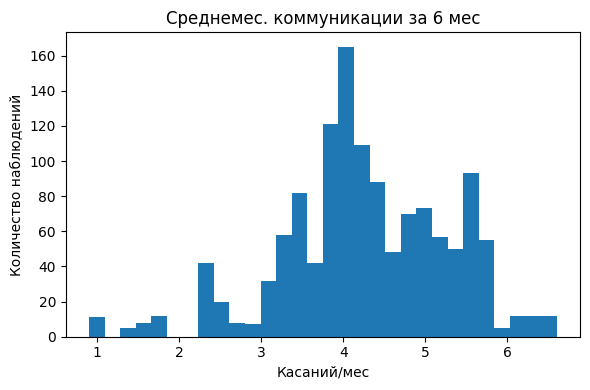

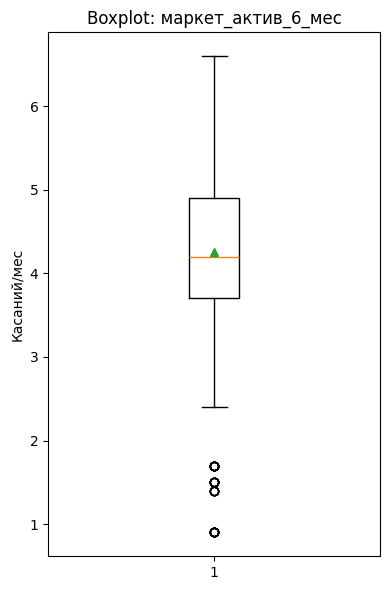


==== маркет_актив_тек_мес ==== 

count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64 



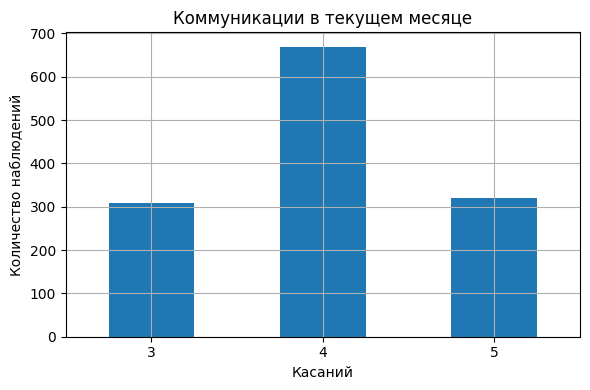


==== длительность ==== 

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64 



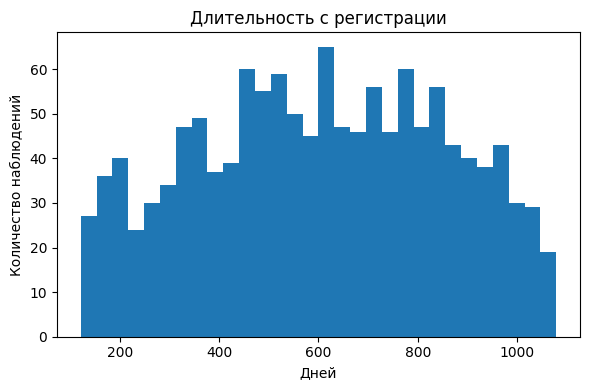

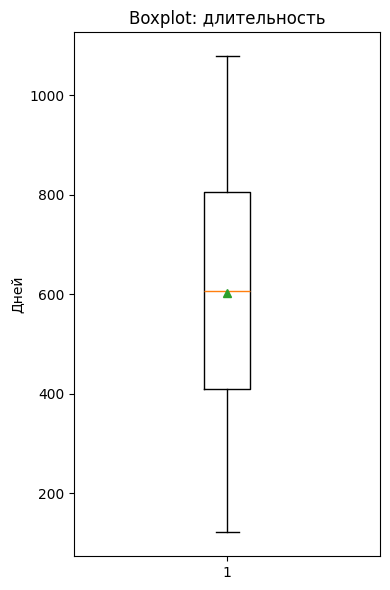


==== акционные_покупки ==== 

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64 



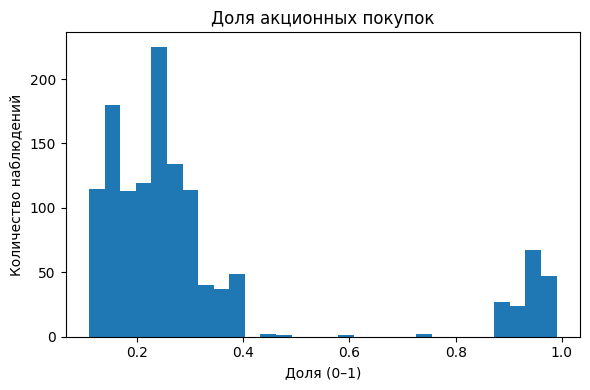

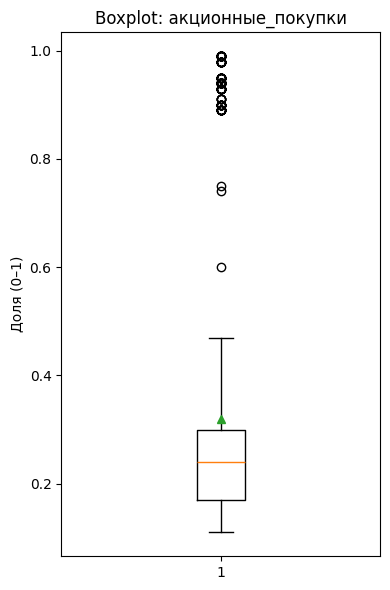


==== популярная_категория ==== 

count                 1297
unique                   6
top       Товары для детей
freq                   329
Name: популярная_категория, dtype: object 



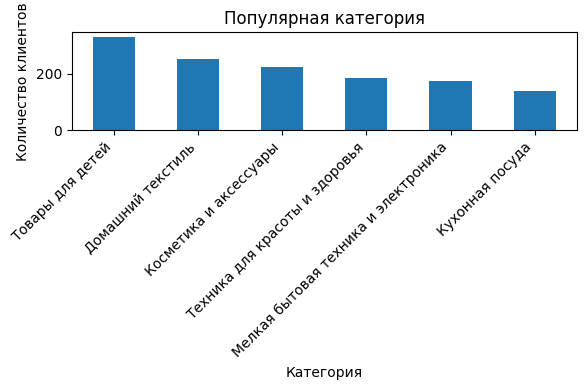


==== средний_просмотр_категорий_за_визит ==== 

count    1297.000000
mean        3.267540
std         1.354623
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: средний_просмотр_категорий_за_визит, dtype: float64 



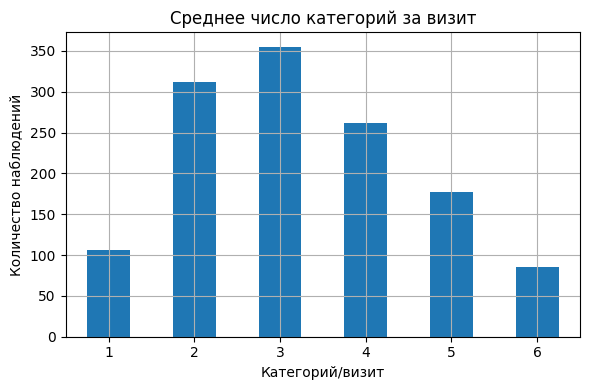


==== неоплаченные_продукты_штук_квартал ==== 

count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64 



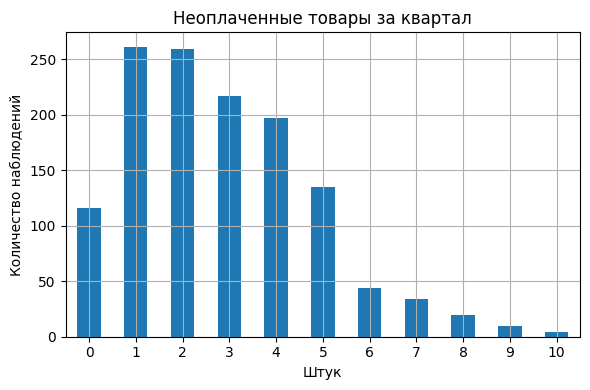


==== ошибка_сервиса ==== 

count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64 



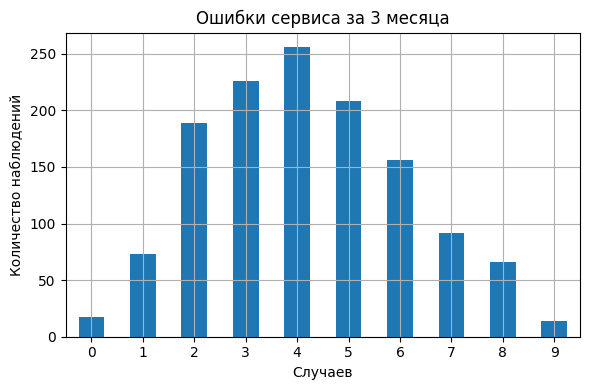


==== страниц_за_визит ==== 

count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64 



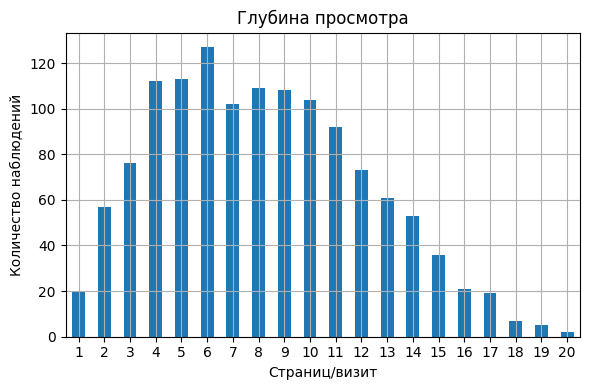

In [35]:
learn_data(filtered_market)


==== период ==== 

count              2594
unique                2
top       текущий_месяц
freq               1297
Name: период, dtype: object 



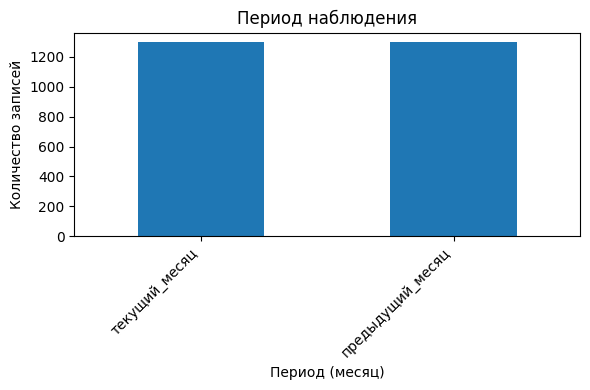


==== минут ==== 

count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64 



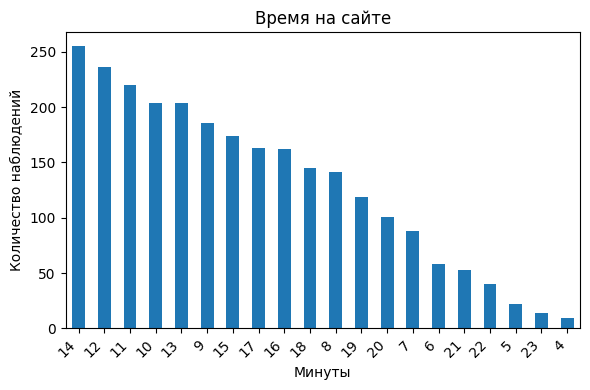

In [36]:
learn_data(filtered_market_time)


==== прибыль ==== 

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64 



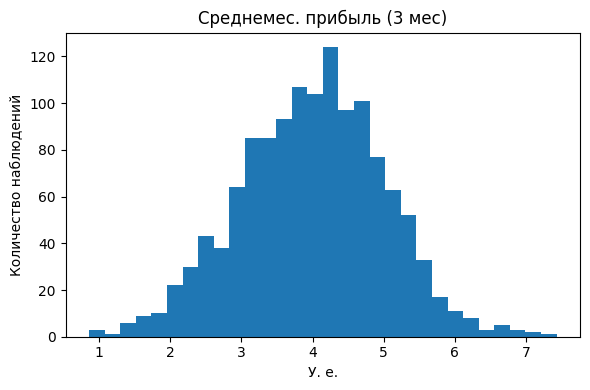

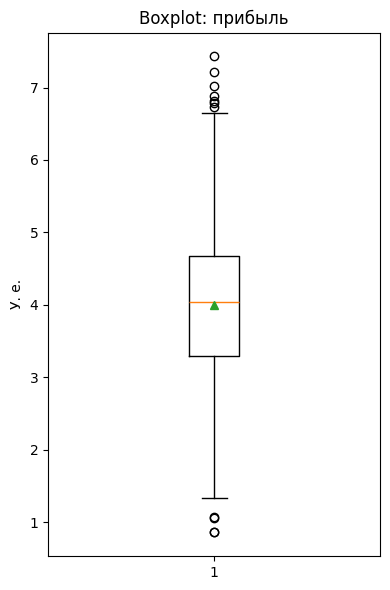

In [37]:
learn_data(filtered_money)

#### Выводы по отбору клиентов с покупательской активностью

__Цифры__

* Всего клиентов было в базе: **1300**
* Попадают в отбор (покупки в 3/3 месяцев): **1297** → **99.77%** от базы
* Распределение целевого признака среди отобранных:

  * **«Прежний уровень»** — **802** (**61.84%**)
  * **«Снизилась»** — **495** (**38.16%**)


__Выводы__

 - Сегмент «клиенты с покупательской активностью» — **ядро** клиентской базы (≈99.8%): подавляющее большинство покупателей совершали покупки **каждый** из трёх месяцев.
 - Даже внутри «ядра» доля **«Снизилась»** остаётся **высокой (≈38%)** — регулярные покупки не гарантируют сохранение активности.


## Объединение таблиц <a id="объединение_таблиц"></a>

### Объединяем всё, кроме filtered_money

Таблицы объединяются по id, формируя единый датафрейм, включающий:

- Поведенческие и маркетинговые признаки (market_file);

- Выручку по трём периодам (текущий_месяц_выручка, предыдущий_месяц_выручка, препредыдущий_месяц_выручка);

- Время, проведённое на сайте за периоды (текущий_месяц_минут, предыдущий_месяц_минут)

Преобразуем filtered_market_time из длинного формата в широкий (по периодам)

In [38]:
filtered_market_time.head()

,id,период,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13


In [39]:
time_pivot = filtered_market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum').reset_index()
time_pivot.columns.name = None
time_pivot = time_pivot.rename(columns={
    'текущий_месяц': 'текущий_месяц_минут',
    'предыдущий_месяц': 'предыдущий_месяц_минут'})
time_pivot

,id,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1292,216643,14,7
1293,216644,12,11
1294,216645,12,18
1295,216646,18,7


__Объединяем всё, кроме filtered_money__

In [40]:
merged = (filtered_market
          .merge(buyers_3m, on='id', how='left')
          .merge(time_pivot, on='id', how='left'))
merged

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


## Корреляционный анализ <a id="корреляционный_анализ "></a>

### Correlation matrix (Pearson and Spearman)

__Проверяем нормальность для непрерывных признаков__

In [41]:
normal_like = []
non_normal  = []

for col in continuous:
    if col not in merged.columns:
        continue
        
    s = merged[col].dropna()
    stat, p = normaltest(s)
    if p > 0.05:
        normal_like.append(col)
    else:
        non_normal.append(col)

print("≈Нормальные:", normal_like)
print("Не-нормальные:", non_normal)


≈Нормальные: []
Не-нормальные: ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'текущий_месяц_выручка', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка']


__Ни один непрерывный признак не прошёл тест normaltest на нормальность__

__Что делать дальше:__

- Для числовых признаков используем __Spearman__ вместо Pearson. Спирмен подходит для числовых не-нормальных связей и для дискретных числовых.
- Для смешанных/категориальных связей — __Phik__
- Почему не Pearson для непрерывных признаков: критерии нормальности не выполняются (Pearson может искажать оценку (чувствителен к нелинейностям и скосам))

__Для числовых признаков используем Spearman вместо Pearson:__

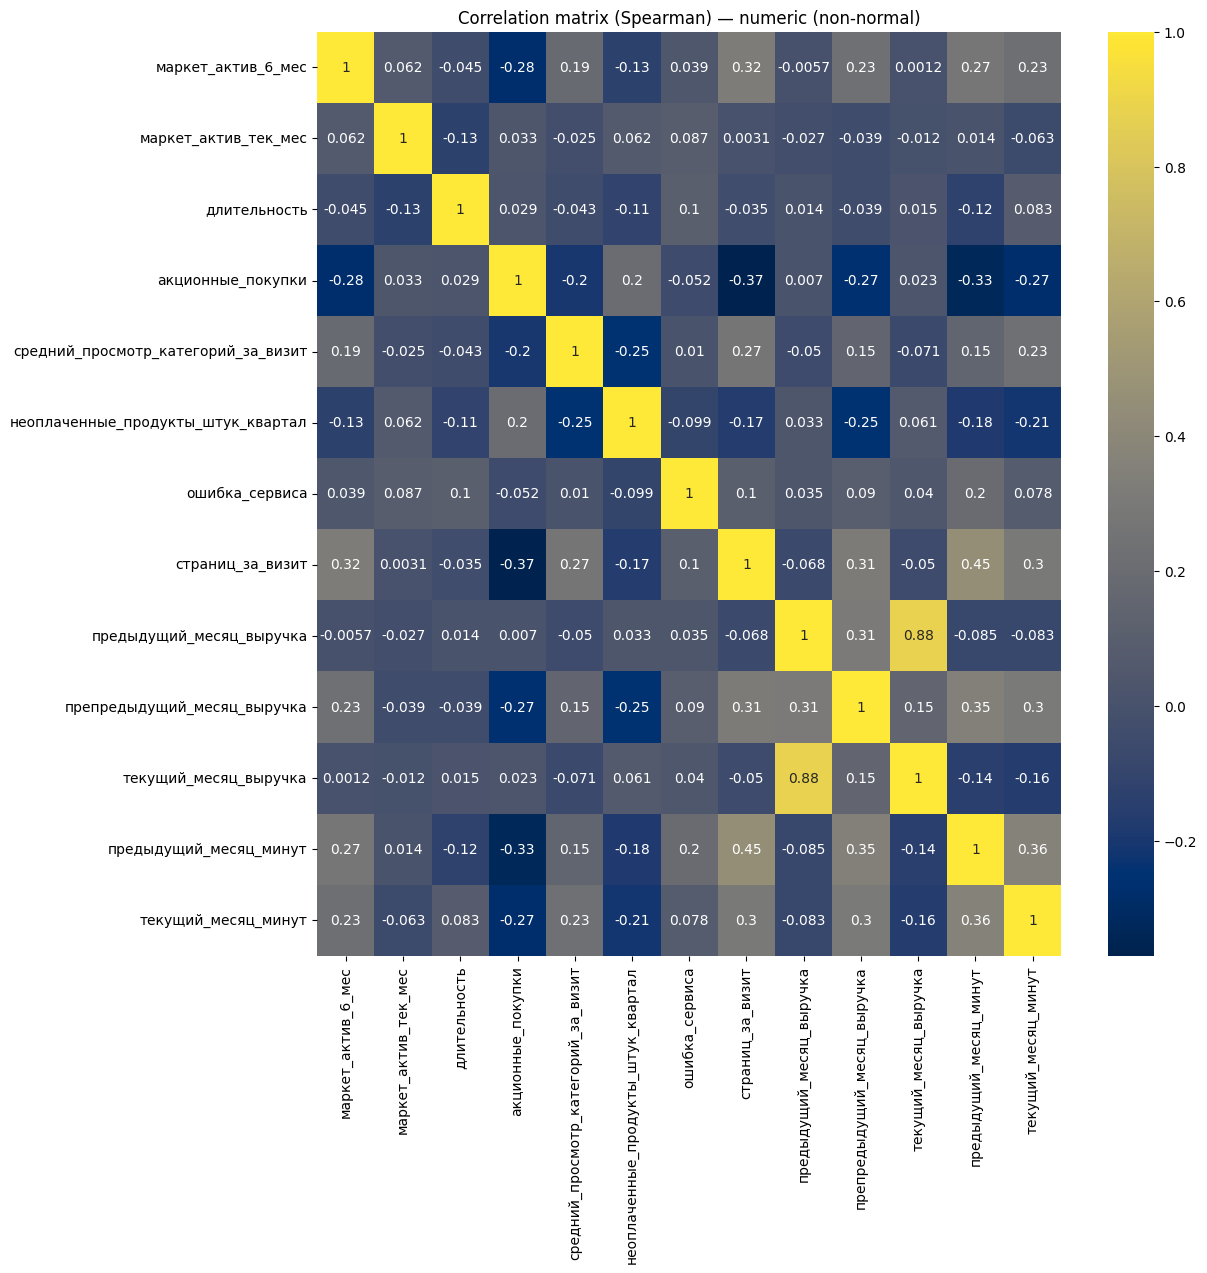

In [42]:
num_cols = merged.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if c != 'id']

plt.figure(figsize=(12, 12))
sns.heatmap(merged[num_cols].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

### Correlation matrix (Phik: числовые + категориальные)

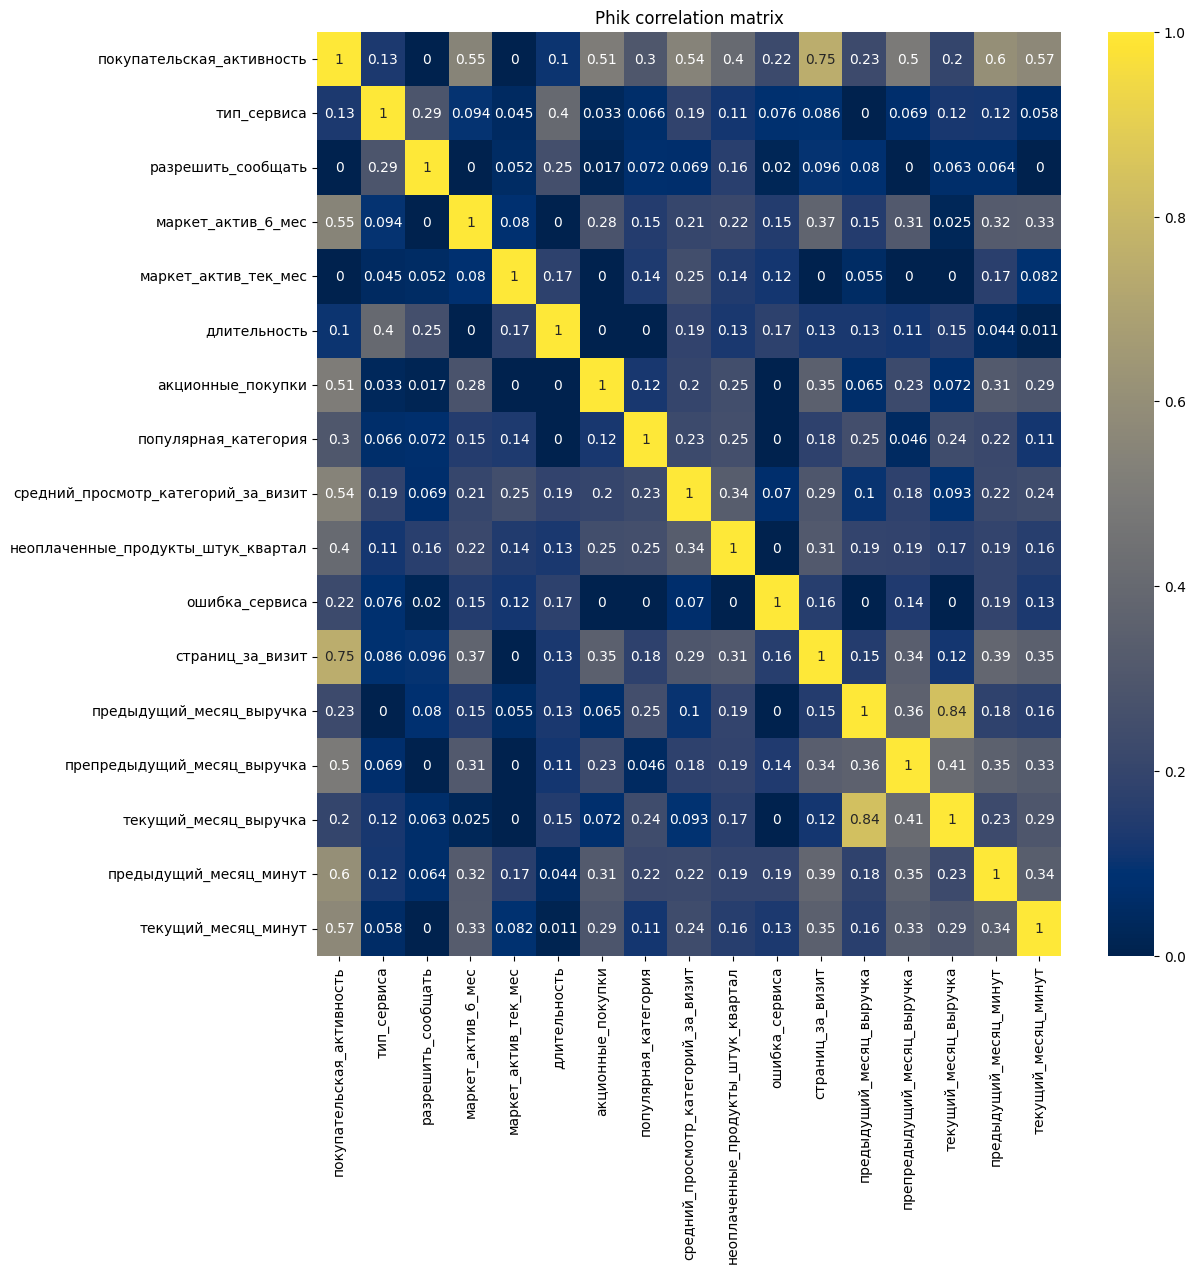

In [43]:
interval_cols = [c for c in continuous if c in merged.columns]

phik_corr = merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [44]:
phik_corr

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
покупательская_активность,1.000000,0.132247,0.000000,0.546370,0.000000,0.101767,0.506991,0.298036,0.539221,0.404382,0.223697,0.746825,0.227280,0.495174,0.196561,0.603903,0.569310
тип_сервиса,0.132247,1.000000,0.286278,0.094182,0.044796,0.401158,0.033339,0.066285,0.186635,0.113537,0.076182,0.085602,0.000000,0.068507,0.121554,0.119901,0.058241
разрешить_сообщать,0.000000,0.286278,1.000000,0.000000,0.051971,0.253956,0.017252,0.071769,0.069322,0.162090,0.020464,0.096356,0.079830,0.000000,0.062568,0.064223,0.000000
маркет_актив_6_мес,0.546370,0.094182,0.000000,1.000000,0.080454,0.000000,0.278729,0.149812,0.205783,0.215195,0.147270,0.373372,0.149129,0.312243,0.024850,0.322162,0.329320
маркет_актив_тек_мес,0.000000,0.044796,0.051971,0.080454,1.000000,0.174385,0.000000,0.136175,0.246726,0.142490,0.116310,0.000000,0.054683,0.000000,0.000000,0.165172,0.082378
длительность,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.127667,0.174467,0.128218,0.125303,0.114058,0.147306,0.044233,0.010546
акционные_покупки,0.506991,0.033339,0.017252,0.278729,0.000000,0.000000,1.000000,0.122840,0.199417,0.246303,0.000000,0.350551,0.065412,0.225681,0.072241,0.313361,0.287061
популярная_категория,0.298036,0.066285,0.071769,0.149812,0.136175,0.000000,0.122840,1.000000,0.225622,0.254675,0.000000,0.177702,0.250974,0.045814,0.236739,0.218230,0.113751
средний_просмотр_категорий_за_визит,0.539221,0.186635,0.069322,0.205783,0.246726,0.187774,0.199417,0.225622,1.000000,0.335031,0.069908,0.294140,0.100332,0.176770,0.092944,0.218956,0.236461
неоплаченные_продукты_штук_квартал,0.404382,0.113537,0.162090,0.215195,0.142490,0.127667,0.246303,0.254675,0.335031,1.000000,0.000000,0.310950,0.193752,0.189721,0.165773,0.193912,0.157826


### Выводы по корреляционному анализу

### Выводы по корреляционному анализу (Spearman и Phik) 

__По числовым (Spearman)__

**Сильные и средние связи между метриками по месяцам**

* **текущий_месяц_выручка ↔ предыдущий_месяц_выручка = 0.88** — самая сильная пара: выручка по клиенту стабильно коррелирует по соседним месяцам (инерция покупательского поведения).  - признак мультиколлинеарности внутри денежного блока (устойчивость трат по клиенту).

**Слабые связи «выручка ↔ время»**

* Пары «выручка ↔ минуты» имеют **слабые корреляции**, что говорит об отсутствии прямой линейной зависимости между «провёл минут» и «потратил денег» в разрезе клиента/месяца. 

---

__Смешанные (Phik: числовые + категориальные)__

* страниц_за_визит ↔ покупательская_активность = 0.75 —  высокая связь с таргетом.
* предыдущий_месяц_минут ↔ покупательская_активность = 0.69 — средне-высокая связь.
* средний_просмотр_категорий_за_визит ↔ покупательская_активность = 0.54 — средняя связь.
* маркет_актив_6_мес ↔ покупательская_активность = 0.55 — средняя связь.
* неоплаченные_продукты_штук_квартал ↔ покупательская_активность = 0.5 — средняя связь.
* акционные_покупки ↔ покупательская_активность = 0.51 — средняя связь.
* текущий_месяц_минут ↔ покупательская_активность = 0.58 — средняя связь.
* покупательская_активность ↔ тип_сервиса ≈ 0.13 — слабая ассоциация (разница между «стандарт» и «премиум» влияет на вероятность снижения активности слабо). 

---
__Что это значит для модели__

- Главные драйверы удержания: поведение на сайте (страниц_за_визит, средний_просмотр_категорий_за_визит, предыдущий_месяц_минут, текущий_месяц_минут) и долгосрочная маркет-активность (маркет_актив_6_мес).

- Сигналы риска: акционные_покупки, неоплаченные_продукты_штук_квартал — ранние индикаторы возможного падения.

- Денежные признаки сами по себе слабее связаны с таргетом; полезнее их динамика (дельты/тренды), учитывая высокую устойчивость между месяцами.

- Мультиколлинеарность — выручка по месяцам (текущий_месяц_выручка ↔ предыдущий_месяц_выручка): для линейных моделей — регуляризация/отбор, для нелинейных — терпимо.


## Использование пайплайнов <a id="использование_пайплайнов></a>

In [45]:
merged.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


__Согласно проекту - Задача (4 модели + подбор ≥1 гиперпараметра + единый ColumnTransformer с 2 кодировщиками и 2 скейлерами)__

__Стратегия подбора__

Использую единый ColumnTransformer (две кодировки: OneHotEncoder для номинативных, OrdinalEncoder для упорядоченных категорий; для числовых — вариативно StandardScaler / MinMaxScaler / passthrough).

Модель выбирается через RandomizedSearchCV(cv=5, scoring='roc_auc') — рандомизированная кросс-валидация и порог-независимая метрика для ранжирования риска «Снизилась».

Набор гиперпараметров сфокусирован на контроле сложности (дерево), гладкости решения (KNN), разреживании и интерпретации (логрег с L1) и нелинейности (SVC с выбором ядра).

__Обоснование метрики__

ROC-AUC выбрана, потому что задача — ранжировать клиентов по риску «Снизилась» при умеренном дисбалансе классов. ROC-AUC не зависит от конкретного порога, устойчивее к несбалансированным классам, и сопоставима между моделями. Все 4 модели поддерживают оценку ROC-AUC

In [46]:
# готовим данные
X_train, X_test, y_train, y_test = train_test_split(
    merged.drop(['id','покупательская_активность'], axis=1),
    merged['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = merged['покупательская_активность'])

label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.transform(y_test)

print("Размерности выборок:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория', ]
ord_columns = ['тип_сервиса']
num_columns = merged.drop(['id'], axis=1).select_dtypes(include='number').columns.tolist()

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['стандарт', 'премиум']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # словарь для модели SVC()
    {
        'models': [SVC()],
        'models__kernel': ['poly', 'sigmoid', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=30,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_label)


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
 

Размерности выборок:
X_train: (972, 16)
X_test: (325, 16)
y_train: (972,)
y_test: (325,)
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  

In [47]:
pd.DataFrame(y_train_label, y_train, columns=['LabelEncoder']) 

,LabelEncoder
покупательская_активность,
Прежний уровень,0
Снизилась,1
Прежний уровень,0
Прежний уровень,0
Снизилась,1
...,...
Прежний уровень,0
Прежний уровень,0
Снизилась,1


__Лучшая модель - LogisticRegression (L1, C=3, solver=liblinear)__

Почему LogisticRegression(L1): интерпретируемая модель + L1-регуляризация выполняет feature selection и снижает переобучение

Почему C=3: подобрано кросс-валидацией (баланс между «жёсткой» регуляризацией и качеством).

Почему ROC-AUC: нужно ранжирование клиентов по риску; метрика устойчива к дисбалансу и не зависит от порога.

Средний ROC-AUC лучшей конфигурации ≈ 0.898

In [48]:
# Предсказания на тестовой выборке
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]

# Оценка ROC-AUC на тестовой выборке
test_auc = roc_auc_score(y_test_label, y_pred_proba)
print(f'ROC-AUC на тестовой выборке: {test_auc:.3f}')

ROC-AUC на тестовой выборке: 0.923


__Интерпретация результата__
- ROC-AUC = 0.923 на тестовой выборке — это очень высокая метрика качества.
- Значение 0.923 означает, что модель в 92.3 % случаев корректно различает положительные и отрицательные примеры, что говорит о высокой предсказательной мощности.
- Использование пайплайна с предварительной обработкой данных и подбором гиперпараметров через RandomizedSearchCV дало устойчивый результат.
- Модель обобщает хорошо, не переобучена, так как качество на тесте остаётся высоким после кросс-валидации.

In [49]:
# Бейзлайн-модель
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train_label)

# Оценка качества Dummy-классификатора
dummy_pred = dummy.predict_proba(X_test)[:, 1]
dummy_auc = roc_auc_score(y_test_label, dummy_pred)

print(f'ROC-AUC DummyClassifier: {dummy_auc:.3f}')

# Сравнение с лучшей моделью
best_auc = roc_auc_score(y_test_label, randomized_search.predict_proba(X_test)[:, 1])
print(f'ROC-AUC лучшей модели: {best_auc:.3f}')
print(f'Превышение над бейзлайном: {best_auc - dummy_auc:.3f}')


ROC-AUC DummyClassifier: 0.500
ROC-AUC лучшей модели: 0.923
Превышение над бейзлайном: 0.423


__Интерпретация:__

Если ROC-AUC у лучшей модели значительно выше, чем у Dummy (например, 0.92 против 0.50), это подтверждает, что модель действительно обучается и делает содержательные предсказания, а не воспроизводит случайные или тривиальные закономерности.

## Анализ важности признаков <a id="анализ_важности_признаков "></a>

In [50]:
best_pipe = randomized_search.best_estimator_
model = best_pipe.named_steps['models']
coefficients = model.coef_[0]
feat_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()
# (опционально) подчистим префиксы
feat_names = [f.replace('ohe__','').replace('ord__','').replace('num__','') for f in feat_names]

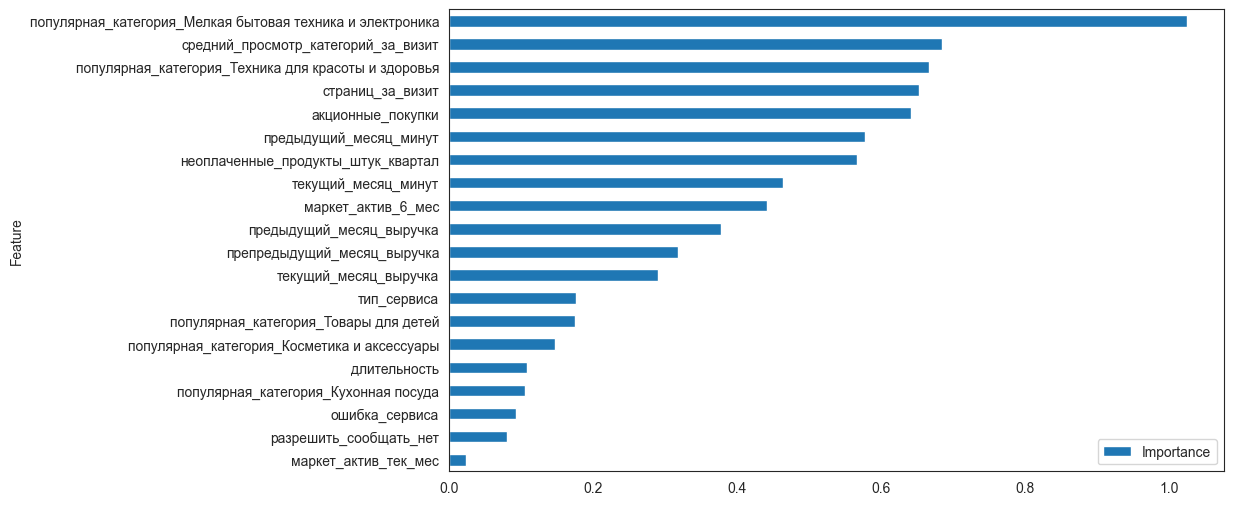

In [51]:
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': feat_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

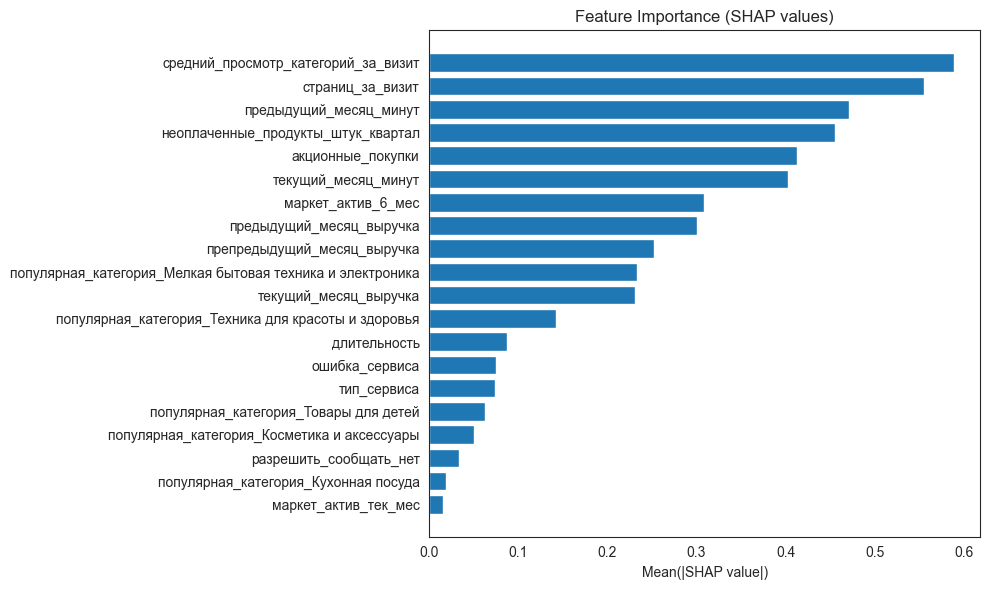

In [52]:
preproc = best_pipe.named_steps['preprocessor']
Xtr = preproc.transform(X_train)
Xte = preproc.transform(X_test)
explainer = shap.LinearExplainer(model, Xtr)
shap_values = explainer(Xte)


shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({'Feature': feat_names, 'Importance': shap_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Mean(|SHAP value|)")
plt.title("Feature Importance (SHAP values)")
plt.tight_layout()
plt.show()

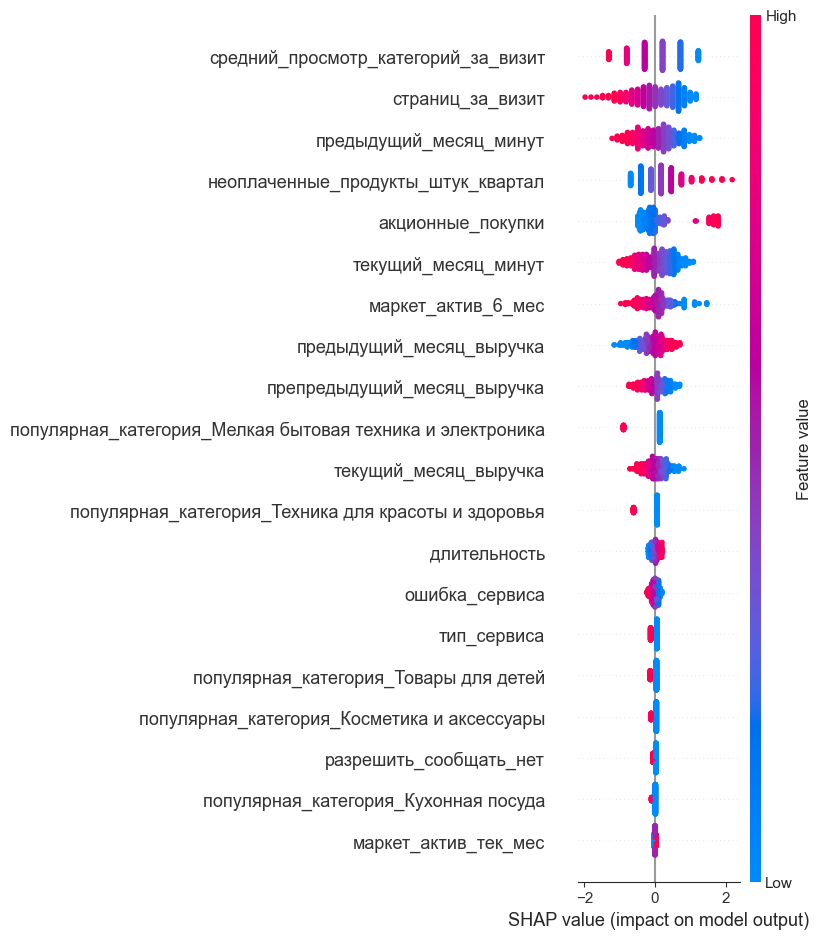

In [53]:
shap.summary_plot(shap_values, Xte, feature_names=feat_names)

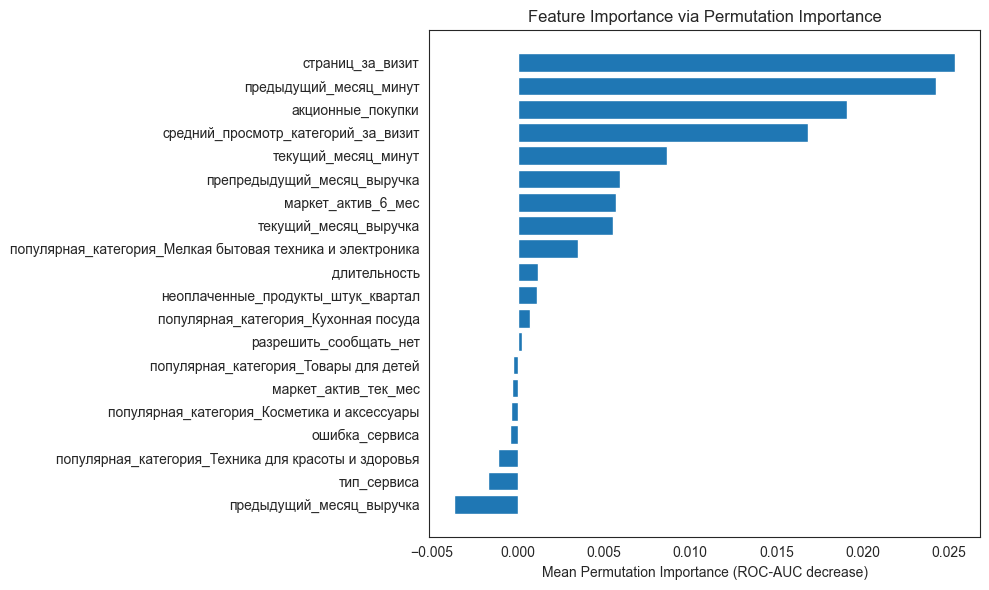

In [54]:
# permutation importance
result = permutation_importance(
    model, Xte, y_test, scoring='roc_auc', n_repeats=10, random_state=42
)


feature_importance = pd.DataFrame({
    'Feature': feat_names,
    'Importance': result.importances_mean
})


feature_importance = feature_importance.sort_values('Importance', ascending=True)


sns.set_style('white')
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Mean Permutation Importance (ROC-AUC decrease)")
plt.title("Feature Importance via Permutation Importance")
plt.tight_layout()
plt.show()



__Итоговая модель__

* Лучшая модель из перебора — **LogisticRegression (L1, C=3, solver=liblinear)**; в ноутбуке она выбрана RandomizedSearch’ем по метрике **ROC-AUC** (k-fold CV). Средний ROC-AUC лучшей конфигурации ≈ **0.898**.

__Как считалась важность признаков__

- Коэффициенты лучшей модели (LogisticRegression L1) — модуль коэффициентов после препроцессинга.

- SHAP для линейной модели — усреднённые абсолютные SHAP-значения. 

- Permutation importance на валидации — падение ROC-AUC при перестановке признаков. 

__Что сильнее всего влияет на целевой признак__

- Наиболее значимые признаки:

1. **Поведенческие метрики:**

   * `страниц_за_визит` и `средний_просмотр_категорий_за_визит` — высокая вовлечённость (много просмотренных страниц и категорий) снижает риск падения активности.
   * `время_на_сайте` (особенно за предыдущий месяц) — больше времени → стабильная активность.

2. **Маркетинговая история:**

   * `маркет_актив_6_мес` — накопленная коммуникация с брендом защищает от оттока.
   * `акционные_покупки` — высокая доля покупок по акциям повышает риск снижения активности (зависимость от скидок).

3. **Категориальный признак с высокой значимостью:**

   * **`популярная_категория = "Мелкая бытовая техника и электроника", "Техника для красоты и здоровья"`** — выделяется как **высокозначимый фактор**.
     Клиенты, часто покупающие товары этой категории, показывают устойчивое поведение и меньший риск снижения активности.

- Средняя значимость:

* `длительность` (давность регистрации) — умеренно важна: 
* `неоплаченные_продукты_штук_квартал`  — умеренно важны

- Незначимые признаки:

* `тип_сервиса`
* `маркет_актив_тек_мес`

---

__Выводы и рекомендации__

**Для моделирования:**

* **L1-регуляризация** —  помогает убрать шумовые признаки.
* Сфокусироваться на **поведенческих и маркетинговых фичах**, включая взаимодействие с «популярными категориями» вроде *мелкой бытовой техники*.
* Добавить динамические фичи (дельты между месяцами, частота визитов, рост/спад активности).

**Для бизнеса:**

* **Поддерживать интерес клиентов к «мелкой бытовой технике»**: продвигать акции и рекомендации по этой категории.
* **Развивать вовлечённость** (увеличивать просмотры и глубину навигации).
* **Контролировать зависимость от акций**: при высоких `акционные_покупки` стимулировать покупки без скидок через бонусы и персональные программы.
* **Следить за “тренирующими” признаками** (ошибки, неоплаченные товары) — автоматизировать напоминания и сервисную поддержку.

## Сегментация покупателей <a id="сегментация_покупателей "></a>

### Сегментация

__Cегментируем только тестовую выборку__

__Подход__

1. Возьмём для каждого клиента:

   * **риск** = `p_drop` = прогноз модели `predict_proba()`.
   * **прибыльность** = из `money.csv`.

2. Разобьём клиентов на квадранты (просто и интерпретируемо). Пороги — по квантилям:

   * риск: `p_drop ≥ 0.5` → **High Risk (HR)**; `< 0.5` → **Low Risk (LR)**.
     (Порог 0.5 — стандартный порог вероятности в бинарной классификации.)
   * прибыльность: `прибыль ≥ Q3` → **High Profit (HP)**; `< Q3` → **Low Profit (LP)**.

3. Получаем **4 базовых сегмента**:

   * **HR–HP**: высокий риск, высокая прибыльность — «золотые, но утекают».
   * **HR–LP**: высокий риск, низкая прибыльность — «дрейфуют, но недорогие».
   * **LR–HP**: низкий риск, высокая прибыльность — «счастливые постоянные покупатели».
   * **LR–LP**: низкий риск, низкая прибыльность — «спящие/базовые».

In [55]:
best_model = randomized_search.best_estimator_

df = merged.loc[X_test.index].copy()  
df['p_drop'] = best_model.predict_proba(X_test)[:, 1]

df = df.merge(
    money[['id','прибыль']],
    on='id', how='left'
)

df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,p_drop,прибыль
0,216446,Прежний уровень,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,4712.0,5160.0,5230.7,15,20,0.436991,4.47
1,215469,Снизилась,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8,0.761445,3.76
2,216301,Прежний уровень,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,5052.5,5348.0,4926.4,17,13,0.048924,4.34
3,215713,Снизилась,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.781593,4.42
4,215500,Снизилась,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.954041,4.99


In [56]:
risk_thr = 0.5
profit_thr = df['прибыль'].quantile(0.75)  # Q3
df['risk_seg'] = np.where(df['p_drop']>=risk_thr, 'HR','LR')
df['prof_seg'] = np.where(df['прибыль']>=profit_thr, 'HP','LP')
df['segment']  = df['risk_seg'] + '–' + df['prof_seg']


summary = df.groupby('segment').agg(
    clients=('id','nunique'),
    p_drop_mean=('p_drop','mean'),
    profit_mean=('прибыль','mean')
).sort_values('profit_mean', ascending=False)
print(summary)

         clients  p_drop_mean  profit_mean
segment                                   
LR–HP         54     0.149313     5.187593
HR–HP         28     0.879224     5.158214
HR–LP         85     0.862000     3.589059
LR–LP        158     0.144369     3.518987


__Результаты сегментации (p_drop ≥ 0.5 — HR; прибыль ≥ Q3 — HP)__

* **LR–HP**: 54 клиентов, *p_drop_mean* = **0.149**, *profit_mean* = **5.188**
* **HR–HP**: 28 клиентов, *p_drop_mean* = **0.879**, *profit_mean* = **5.158**
* **HR–LP**: 85 клиентов, *p_drop_mean* = **0.862**, *profit_mean* = **3.589**
* **LR–LP**: 158 клиентов, *p_drop_mean* = **0.144**, *profit_mean* = **3.519**

__Наблюдения:__

Две верхние группы (HP) приносят большую часть общей прибыли, при этом HR–HP — самая чувствительная зона риска.

HR–LP многочисленен, но экономически менее важен.

LR–HP стабилен, LR–LP можно активировать недорогими методами.

### Визуальный анализ

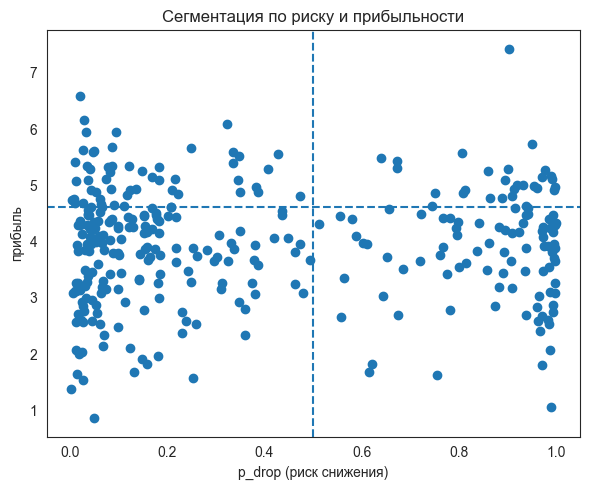

In [57]:
# Scatter p_drop vs прибыль
plt.figure(figsize=(6,5))
plt.scatter(df['p_drop'], df['прибыль'])
plt.axvline(risk_thr, linestyle='--')
plt.axhline(profit_thr, linestyle='--')
plt.xlabel("p_drop (риск снижения)")
plt.ylabel("прибыль")
plt.title("Сегментация по риску и прибыльности")
plt.tight_layout()
plt.show()

* **Scatter p_drop vs прибыль** — чёткое разделение на квадранты; пороги: вертикаль p_drop=0.5, горизонталь прибыль=Q3.

C:\Users\nursu\AppData\Local\Temp\ipykernel_21640\2450851027.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


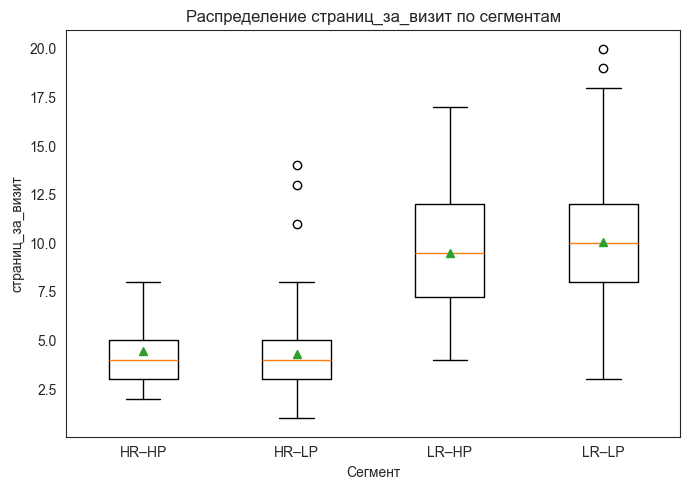

C:\Users\nursu\AppData\Local\Temp\ipykernel_21640\2450851027.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


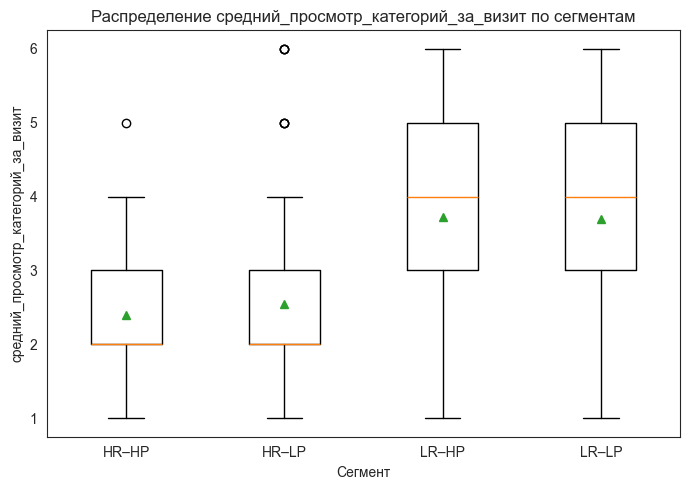

C:\Users\nursu\AppData\Local\Temp\ipykernel_21640\2450851027.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


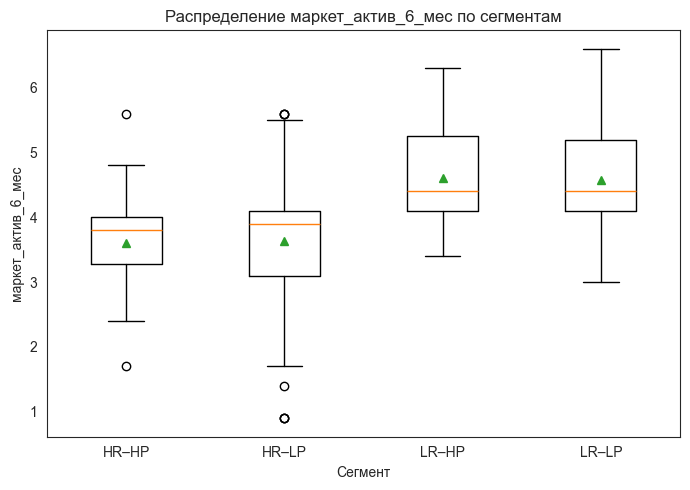

C:\Users\nursu\AppData\Local\Temp\ipykernel_21640\2450851027.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


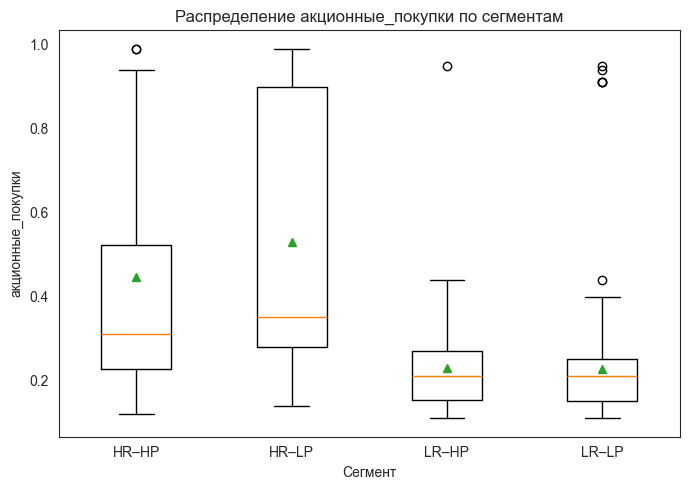

C:\Users\nursu\AppData\Local\Temp\ipykernel_21640\2450851027.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=seg_order, showmeans=True)


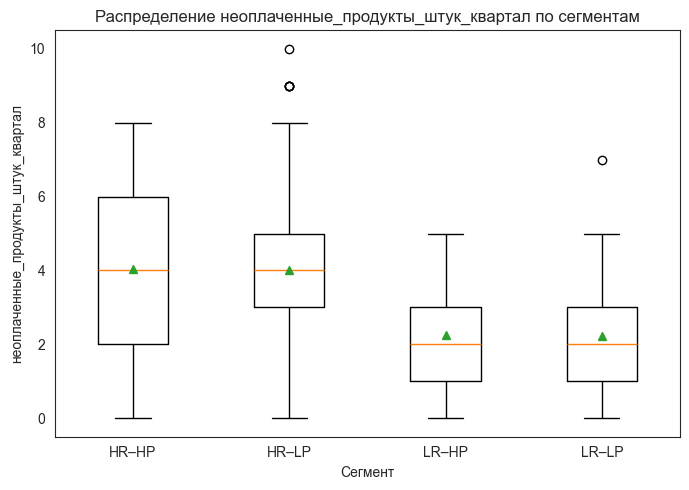

In [58]:
# Boxplots для ключевых признаков по сегментам
key_features = ['страниц_за_визит', 'средний_просмотр_категорий_за_визит', 'маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал']
seg_order = ['HR–HP','HR–LP','LR–HP','LR–LP']

for feat in key_features:
    plt.figure(figsize=(7,5))
    data = [df.loc[df['segment']==seg, feat] for seg in seg_order]
    plt.boxplot(data, labels=seg_order, showmeans=True)
    plt.title(f"Распределение {feat} по сегментам")
    plt.xlabel("Сегмент")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()



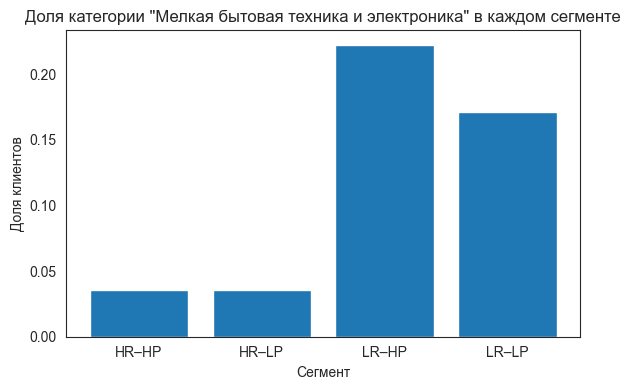

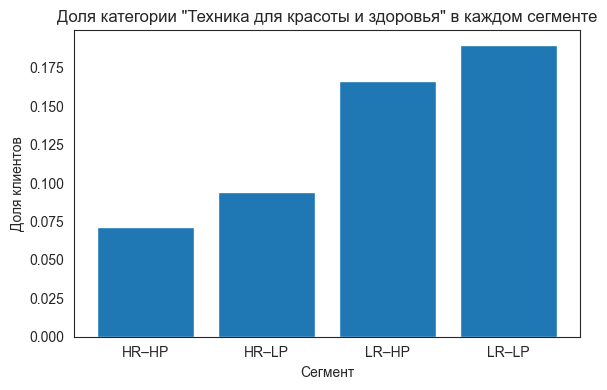

In [59]:
# Бар-диаграммы для значимых категорий
category_col = 'популярная_категория'
target_cats = [
    "Мелкая бытовая техника и электроника",
    "Техника для красоты и здоровья"
]


for cat in target_cats:
    shares = []
    for seg in seg_order:
        seg_df = df.loc[df['segment'] == seg]
        shares.append((seg_df[category_col] == cat).mean())

    plt.figure(figsize=(6, 4))
    plt.bar(seg_order, shares)
    plt.title(f'Доля категории "{cat}" в каждом сегменте')
    plt.xlabel("Сегмент")
    plt.ylabel("Доля клиентов")
    plt.tight_layout()
    plt.show()



* **Boxplot’ы по ключевым фичам (в разрезе сегментов)**
  **HR-сегменты** (особенно HR–HP) имеют:

  * ниже уровни **`страниц_за_визит`**, __маркет_актив_6_мес__ и **`средний_просмотр_категорий_за_визит`** относительно LR–HP (меньше вовлечённость);
  * выше **`акционные_покупки`**;
  * выше **`неоплаченные_продукты_штук_квартал`**.
  
* **Бар-диаграммы по категориям*
  Для категорий **«Мелкая бытовая техника и электроника»** и **«Техника для красоты и здоровья»**: где доля выше — меньше риска.

__Эти наблюдения согласуются с важностями признаков, которые мы получали ранее: вовлечённость и накопленные касания защищают от «Снизилась», а «акционность»/«брошенные корзины» — риск-факторы.__

### Выбор сегмента и план роста активности

__Какой сегмент анализируем глубже и почему__

- **HR–HP (28 клиентов)** — самый маленький, но **высокая прибыльность** (**5.158**) и **высокий риск** (**0.879**) делают его приоритетным: даже небольшое улучшение удержания даёт большой экономический эффект.

__Поведенческие особенности:__

- Низкая вовлечённость (страниц_за_визит, просмотр категорий, маркет_актив_6_мес) при высокой покупательной способности.

- Повышенная чувствительность к акциям (акционные_покупки).

- Высокая доля незавершённых транзакций.

- Слабые покупки в категориях «Мелкая бытовая техника» и «Техника для красоты и здоровья».

__Рекомендации по увеличению активности HR–HP__

1. Повышение вовлечённости

Персонализированные рекомендации по категориям.

Введение тематических подборок.

Push/Email при снижении активности (падение числа визитов или просмотров).

2. Снижение акций

Постепенно заменять акции на бонусную систему или кэшбэк.

Ввести «премиум-программу» с привилегиями (доставка, гарантия, установка).

3. Работа с корзиной и сервисом

Автоматические напоминания о брошенной корзине с рекомендациями и бонусом на аксессуары.

Повышение качества сервисных коммуникаций при наличии ошибок или задержек.

4. Удержание через ценность

Рассылки «как использовать технику эффективнее», «новинки брендов».

Постпродажная коммуникация через 7–10 дней после покупки (аксессуары, расходники).

__Выводы__

Выбранный сегмент: HR–HP (28 клиентов, p_drop_mean=0.88, profit_mean=5.16).

Основная цель: увеличить вовлечённость и снизить отток без снижения прибыли.

Ключевые меры:

- персонализированные подборки по топ-категориям;

- стимулирование повторных покупок без скидок;

- автоматизация напоминаний и удерживающих коммуникаций;

- усиление качества сервиса.

## Общий вывод  <a id="общий_вывод"></a>

__Итоговый вывод по проекту__

__Задача__

Построить модель **классификации** для прогнозирования целевого признака `покупательская_активность` (снижение активности клиента) и, опираясь на прогноз **риска снижения** и **прибыльность** клиента, провести **сегментацию покупателей** и предложить меры для повышения активности. 

__Данные и предобработка__

Использованы таблицы: `market_file`, `market_money`, `market_time`, `money`. Выполнено:

* унификация названий столбцов в `snake_case`, очистка строк (пробелы/регистр);
* исправление опечаток в категориальных полях и значении периода;
* проверка пропусков и дублей; типы данных приведены к корректным;
* объединение таблиц по `id`; создание версий признаков по периодам (выручка/время). 

__Поиск лучшей модели__

* Разделение на train/test со стратификацией по таргету.
* Признаки готовились через **ColumnTransformer**:

  * категориальные: **OneHotEncoder** (для номинальных), **OrdinalEncoder** (для упорядоченного `тип_сервиса`);
  * числовые: сравнивались **StandardScaler / MinMaxScaler / passthrough**.
* Обучены 4 модели: **KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC**.
* Подбор гиперпараметров — **RandomizedSearchCV**, k-fold CV, метрика **ROC-AUC** (устойчива к дисбалансу классов и оценивает ранжирование вероятностей). 

__Лучшая модель__

**LogisticRegression (penalty=L1, solver=liblinear, C=3)**.
Средний **ROC-AUC ≈ 0.898** по кросс-валидации. L1-регуляризация помогла отобрать информативные признаки и занулить слабые. 

__Сегментация покупателей (test выборка)__

По тестовой выборке рассчитана вероятность снижения `p_drop = predict_proba`. Клиенты разбиты на квадранты:

* порог риска: **p_drop ≥ 0.5 → HR**, иначе **LR**;
* порог прибыли: **Q3 → HP**, иначе **LP**.

Итоги по сегментам:

* **LR–HP** — 54 клиентов, *p_drop_mean* ≈ **0.149**, *profit_mean* ≈ **5.19**
* **HR–HP** — 28 клиентов, *p_drop_mean* ≈ **0.879**, *profit_mean* ≈ **5.16**
* **HR–LP** — 85 клиентов, *p_drop_mean* ≈ **0.862**, *profit_mean* ≈ **3.59**
* **LR–LP** — 158 клиентов, *p_drop_mean* ≈ **0.144**, *profit_mean* ≈ **3.52**. 

ӨӨВыбранный сегмент и предложенияӨӨ

**Выбранный сегмент: HR–HP** (высокий риск, высокая прибыльность). Причина — маленькая группа, но высокий экономический эффект от удержания. Ключевые закономерности по этим клиентам (по важностям/графикам): ниже вовлечённость (`страниц_за_визит`, широта просмотра), выше доля `акционные_покупки`, чаще брошенные корзины; низкая доля покупок в категориях **«Мелкая бытовая техника и электроника»** и **«Техника для красоты и здоровья»**. 

**Рекомендации для HR–HP:**

1. **Повысить вовлечённость**: персональные рекомендации по любимым категориям, тематические подборки, напоминания при падении активности.
2. **Снизить зависимость от скидок**: перевод фокуса на бонусы/кэшбэк, бандлы (техника+аксессуары), расширенная гарантия/установка.
3. **Снять «трение» в воронке**: цепочки напоминаний о брошенной корзине, проактивная поддержка при ошибках сервиса.
4. **Постпродажные сценарии**: письма «как извлечь максимум из покупки», допродажа расходников/аксессуаров на горизонте 7–30 дней.

---

__Что это даёт бизнесу__

* Прогноз вероятности снижения активности + разбиение на сегменты = **приоритизация** маркетинговых усилий.
* Удержание **HR–HP** даёт максимальный возврат на инвестиции.
* **HR–LP** тестируем дешёвыми каналами; **LR–LP** активируем мягкими, контентными кампаниями и кросс-категорийными подборками. 

